### Notebook to perform the regression between the wind contribution to sea level rise at the Dutch coast and SST across the North Atlantic

The aim of this notebook is to obtain how the sea surface temperature can explain the wind contribution to sea level at the Dutch coast.

In [5]:
# Import necessary packages and methods
from scipy.signal import detrend
from xscale.signal.fitting import detrend as xdetrend
import copy
import numpy as np
import xarray as xr
import pandas as pd
from sklearn.linear_model import LinearRegression as linr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels as sm
import copy
import cartopy.crs as ccrs

# Declare global variables
lowess = sm.nonparametric.smoothers_lowess.lowess
window = 20

In [6]:
# Declare paths to data 
path_data_SST = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Github/Thesis-KNMI/SST/Data/'
path_data_windSLC_20CR = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Github/Thesis-KNMI/AMV/Data/Wind/1836_2015/'
path_data_windSLC_ERA5 = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Github/Thesis-KNMI/AMV/Data/Wind/1950_2020/'

# Declare path for saving figures
plot_path = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Github/Thesis-KNMI/SST/Figures/Regression/'

### Import and plot wind contribution to sea level data

In [7]:
def get_frac(window, data, dtype='DataFrame'):
    if dtype == 'DataFrame':
        frac = window / (data.index[-1]-data.index[0])
    elif dtype == 'DataArray':
        frac = window / (data.year.values[-1] - data.year.values[0])
    else: print('Datatype unknown')
    
    return frac

In [8]:
# Import dataframes for comparison
def import_windSLC_data(path, data = 'ERA5'):
    
    
    if data == 'ERA5':
        
        timeseries_dang_path = path +'timeseries_df_dang_ERA5_' 
        timeseries_tim_path = path +'timeseries_df_tim_ERA5_' 
        timeseries_np_path = path +'timeseries_df_np_ERA5_' 
        
    elif data == '20CR':

        timeseries_dang_path = path +'timeseries_df_dang_20CR_' 
        timeseries_tim_path = path +'timeseries_df_tim_20CR_' 
        timeseries_np_path = path +'timeseries_df_np_20CR_'  
        
    
    df_dang = pd.read_csv(timeseries_dang_path+'Average'+'.csv')
    df_dang = df_dang.rename(columns={df_dang.columns[-1]: "Wind total"})
    df_dang = pd.DataFrame(data={'time': df_dang.time, 'Average':df_dang['Wind total']})
    df_dang = df_dang.set_index('time')
        
    df_tim = pd.read_csv(timeseries_tim_path+'Average'+'.csv')
    df_tim = pd.DataFrame(data={'time': df_tim.time, 'Average':df_tim['Wind total']})
    df_tim = df_tim.set_index('time')

    df_np = pd.read_csv(timeseries_np_path+'Average'+'.csv')
    df_np = pd.DataFrame(data={'time': df_np.time, 'Average':df_np['Wind total']})
    df_np = df_np.set_index('time')
    
    # Detrend dataframes
    df_dang['Average'] = detrend(df_dang['Average'])
    df_tim['Average'] = detrend(df_tim['Average'])
    df_np['Average'] = detrend(df_np['Average'])
        
    # Apply low pass filter (LOWESS)
    df_dang['Average'] = lowess(df_dang['Average'].values,df_dang.index.values,
                                         get_frac(window, df_dang, dtype='DataFrame'), 
                                         return_sorted = False)
    df_tim['Average'] = lowess(df_tim['Average'].values,df_tim.index.values, 
                                        get_frac(window, df_tim, dtype='DataFrame'), 
                                        return_sorted = False)
    df_np['Average'] = lowess(df_np['Average'].values,df_np.index.values, 
                                       get_frac(window, df_np, dtype='DataFrame'), 
                                       return_sorted = False)
    
    return (df_dang, df_tim, df_np)

In [9]:
wind_contr_SLH_dang_20CR, wind_contr_SLH_tim_20CR, wind_contr_SLH_np_20CR = import_windSLC_data(path_data_windSLC_20CR, data = '20CR')
wind_contr_SLH_dang_ERA5, wind_contr_SLH_tim_ERA5, wind_contr_SLH_np_ERA5 = import_windSLC_data(path_data_windSLC_ERA5, data = 'ERA5')

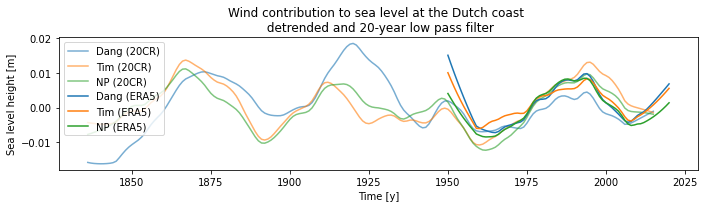

In [10]:
# Plot wind contribution of different methods for the average stations
plt.figure(figsize=(10,3))
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.plot(wind_contr_SLH_dang_20CR.index, wind_contr_SLH_dang_20CR['Average'], label = 'Dang (20CR)', alpha=0.6, color = colors[0])
plt.plot(wind_contr_SLH_tim_20CR.index, wind_contr_SLH_tim_20CR['Average'], label = 'Tim (20CR)', alpha=0.6, color = colors[1])
plt.plot(wind_contr_SLH_np_20CR.index, wind_contr_SLH_np_20CR['Average'], label = 'NP (20CR)', alpha=0.6, color = colors[2])
plt.plot(wind_contr_SLH_dang_ERA5.index, wind_contr_SLH_dang_ERA5['Average'], label = 'Dang (ERA5)', color = colors[0])
plt.plot(wind_contr_SLH_tim_ERA5.index, wind_contr_SLH_tim_ERA5['Average'], label = 'Tim (ERA5)', color = colors[1])
plt.plot(wind_contr_SLH_np_ERA5.index, wind_contr_SLH_np_ERA5['Average'], label = 'NP (ERA5)', color = colors[2])
plt.title('Wind contribution to sea level at the Dutch coast \n detrended and ' + str(window) +'-year low pass filter')
plt.ylabel('Sea level height [m]')
plt.xlabel('Time [y]')
plt.legend()
plt.tight_layout()
plt.savefig(plot_path+'wind_contr_SLH2' + str(window) +'.png')

In [11]:
wind_data = [wind_contr_SLH_dang_20CR, wind_contr_SLH_tim_20CR, wind_contr_SLH_np_20CR, 
             wind_contr_SLH_dang_ERA5, wind_contr_SLH_tim_ERA5, wind_contr_SLH_np_ERA5]

### Import the SST and SKT data over the North Atlantic

SST: sea surface temperature (NOAA Extended Reconstructed Sea Surface Temperature (SST) V5)

SKT: skin temperature? (NOAA-CIRES-DOE Twentieth Century Reanalysis (V3))

In [12]:
# Function that detrends the data from a dataarray
def detrend_dim(da, dim, deg=1): # deg=1 for linear fit
        # detrend along a single dimension
        p = da.polyfit(dim=dim, deg=deg)
        coord = da.year - da.year.values[0]
        trend = coord*p.polyfit_coefficients.sel(degree=1)
        return da - trend

In [13]:
# Function that selects a given region of data for xarray dataset        
def xr_select_region(data, coords):
    # Coords should have shape: [longitude minimum, longitude maximum, latitude minimum, latitude maximum]
    data = data.where(data.lon>=coords[0], drop=True)
    data = data.where(data.lon<=coords[1], drop=True)
    data = data.where(data.lat>=coords[2], drop=True)
    data = data.where(data.lat<=coords[3], drop=True)
    return data

In [14]:
# Import SST and SKT data
SKT = xr.open_dataset(path_data_SST + 'skt.mon.mean.nc') 
SST = xr.open_dataset(path_data_SST + 'sst.mnmean.nc') 

# Obtain annual averages 
SKT = SKT.groupby('time.year').mean('time')
SST = SST.groupby('time.year').mean('time')

# Delete 2021
SKT = SKT.where((SKT.year<2021), drop=True)
SST = SST.where((SST.year<2021), drop=True)

# Shift longitudes to -180-180
SKT.coords['lon'] = (SKT.lon + 180) % 360 - 180
SST.coords['lon'] = (SST.lon + 180) % 360 - 180

# Sort dataarrays
SKT = SKT.sortby(SKT.lon, ascending=True)
SKT = SKT.sortby(SKT.lat, ascending=True)
SST = SST.sortby(SST.lon, ascending=True)
SST = SST.sortby(SST.lat, ascending=True)

# Select North Atlantic region
SKT = xr_select_region(SKT, [-100, 10, 0, 88])
SST = xr_select_region(SST, [-100, 10, 0, 88])

# Change dataset to dataarray
SKT = SKT.skt
SST = SST.sst

# Select same region for both dataarrays
SKT = SKT.where(SST.notnull(), drop=True)
SST = SST.where(SKT.notnull(), drop=True)

# Drop nan values
#SKT = SKT.dropna('year', how='all')
#SST = SST.dropna('year', how='all')

# Remove trend from data
SKT = detrend_dim(SKT, 'year')
SST = detrend_dim(SST, 'year')

# Convert SST from degree Celsius to degree Kelvin
SST = SST + 273.15

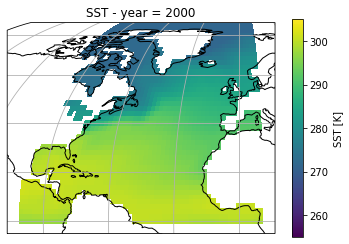

In [15]:
# Plot SST for the year 2000

fig = plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
SST.sel(year=2000,method='Nearest').plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'SST [K]'}, 
                        vmin=255, vmax=305)
plt.title('SST - year = 2000')
plt.savefig(plot_path+'SST' + str(2000) +'.png', bbox_inches='tight')

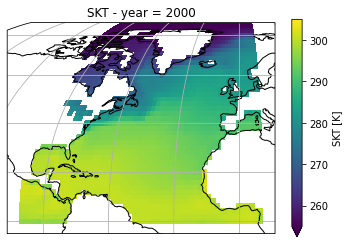

In [16]:
# Plot SKT for the year 2000

fig = plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
SKT.sel(year=2000,method='Nearest').plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'SKT [K]'}, 
                        vmin=255, vmax=305)
plt.title('SKT - year = 2000')
plt.savefig(plot_path+'SKT' + str(2000) +'.png', bbox_inches='tight')

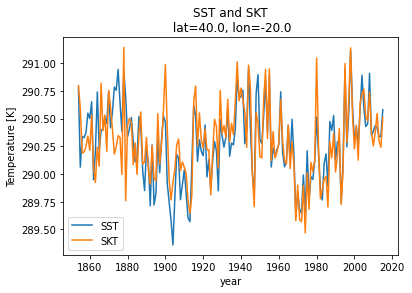

In [17]:
# Plot SST and SKT for some location
SST.sel(lat=40,lon=-20,method='Nearest').plot(label='SST')
SKT.sel(lat=40,lon=-20,method='Nearest').plot(label='SKT')
plt.title('SST and SKT\n lat=40.0, lon=-20.0')
plt.legend()
plt.ylabel('Temperature [K]')
plt.savefig(plot_path+'SST_lat40_lon20.png', bbox_inches='tight')


In [18]:
# Apply low pass filter (LOWESS)
years = SST.year.values
frac = get_frac(window, SST, dtype='DataArray')

def lowess_1d(SST):
    return lowess(SST, years, frac, return_sorted = False)

SST_low = xr.apply_ufunc(lowess_1d, # The 1D function followed by its arguments
                         SST,
                         input_core_dims=[['year']],
                         output_core_dims = [['year']],
                         vectorize = True,
                        )

/Users/iriskeizer/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/iriskeizer/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
# Apply low pass filter (LOWESS)
years = SKT.year.values
frac = get_frac(window, SKT, dtype='DataArray')

def lowess_1d(SST):
    return lowess(SST, years, frac, return_sorted = False)

SKT_low = xr.apply_ufunc(lowess_1d, # The 1D function followed by its arguments
                         SKT,
                         input_core_dims=[['year']],
                         output_core_dims = [['year']],
                         vectorize = True,
                        )

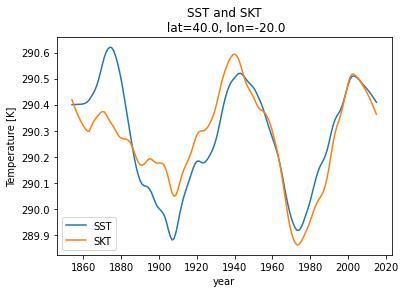

In [20]:
# Plot SST_low for some location
SST_low.sel(lat=40,lon=-20,method='Nearest').plot(label='SST')
SKT_low.sel(lat=40,lon=-20,method='Nearest').plot(label='SKT')
plt.title('SST and SKT\n lat=40.0, lon=-20.0')
plt.legend()
plt.ylabel('Temperature [K]')
plt.savefig(plot_path+'SST_SKT_low_lat40_lon20.png', bbox_inches='tight')

### Perform regression between wind contribution to sea level and SST

In [21]:
def significance_test(p, alpha):
    if p < alpha: return True
    else: return False

In [22]:
def regression(data_x, data_y, significance_level):
    x_l = pd.DataFrame(data={'year': data_x.year, 'SST':data_x})
    x_l = x_l.set_index('year')
    x_l = x_l.dropna()
    
    if x_l.size == 0: return data_x.reset_coords('degree', drop=True), np.nan, np.nan, np.nan
    
    y_l = copy.deepcopy(data_y['Average'])
        
    # Standardize x
    scaler = StandardScaler()
    x_l = copy.deepcopy(x_l)
    x_l.iloc[:,:] = scaler.fit_transform(x_l)
        
    # Create dataseries of equal time span
    y = y_l[y_l.index.isin(x_l.index)]
    x = x_l[x_l.index.isin(y.index)]

    # Fit the regression model
    linear_regression = linr()
    fit = linear_regression.fit(x, y)
    r2 = linear_regression.score(x, y)
    intercept = linear_regression.intercept_
    coefs = linear_regression.coef_.tolist()[0]
    timeseries = coefs*x_l['SST']
    SST_reg_timeseries = xr.DataArray(data=timeseries ,dims=["year"],
                                      coords=dict(year=timeseries.index.values,),)
        
    yhat = linear_regression.predict(x)
    mse = mean_squared_error(y, yhat) # Calculate insample mse (non-negative)
    rmse = np.sqrt(mse)
    f_statistic, p_values = f_regression(x, y)
    
    # Check significance
    significance = significance_test(p_values[0], 1-significance_level/100)
    
    if significance == False:
        r2 = np.nan
        rmse =  np.nan
    
    return SST_reg_timeseries, rmse, r2, significance

### Perform regression with SST

In [31]:
wind_names = ['dang_20CR', 'tim_20CR', 'np_20CR', 
              'dang_ERA5', 'tim_ERA5', 'np_ERA5']

ts_lst2, rmse_lst2, r2_lst2, sig_lst2 = [], [], [], []
for data_y in wind_data:
    ts_lst1, rmse_lst1, r2_lst1, sig_lst1 = [], [], [], []
    for lon in SST_low.lon.values:
        ts_lst0, rmse_lst0, r2_lst0, sig_lst0 = [], [], [], []
        for lat in SST_low.lat.values:
            ts, rmse, r2, sig = regression(SST_low.sel(lat=lat, lon=lon, drop=True), data_y, 90)
            ts_lst0.append(ts)
            rmse_lst0.append(rmse)
            r2_lst0.append(r2)
            sig_lst0.append(sig)
        ts_lst1.append(xr.concat(ts_lst0, dim=SST_low.lat.values).rename({"concat_dim":"lat"}))
        rmse_lst1.append(xr.DataArray(data=rmse_lst0 ,dims=["lat"],
                                      coords=dict(lat=SST_low.lat.values,),))
        r2_lst1.append(xr.DataArray(data=r2_lst0 ,dims=["lat"],
                                      coords=dict(lat=SST_low.lat.values,),))
        sig_lst1.append(xr.DataArray(data=sig_lst0 ,dims=["lat"],
                                      coords=dict(lat=SST_low.lat.values,),))
    ts_lst2.append(xr.concat(ts_lst1, dim=SST_low.lon.values).rename({"concat_dim":"lon"}))
    rmse_lst2.append(xr.concat(rmse_lst1, dim=SST_low.lon.values).rename({"concat_dim":"lon"}))
    r2_lst2.append(xr.concat(r2_lst1, dim=SST_low.lon.values).rename({"concat_dim":"lon"}))
    sig_lst2.append(xr.concat(sig_lst1, dim=SST_low.lon.values).rename({"concat_dim":"lon"}))

SST_ts = xr.concat(ts_lst2, dim=wind_names).rename({"concat_dim":"model"})
SST_rmse = xr.concat(rmse_lst2, dim=wind_names).rename({"concat_dim":"model"})
SST_r2 = xr.concat(r2_lst2, dim=wind_names).rename({"concat_dim":"model"})
SST_sig = xr.concat(sig_lst2, dim=wind_names).rename({"concat_dim":"model"})

In [32]:
def plot_all_models2(data, label, save_name):
    cbar_kwargs = {'orientation': 'vertical','label': label}
    fg = data.plot(x='lon', y='lat', col='model', col_wrap=3, 
              transform=ccrs.PlateCarree(),
              subplot_kws={"projection": ccrs.Robinson()},
              robust=True, cbar_kwargs=cbar_kwargs)
    fg.map(lambda: plt.gca().coastlines())
    plt.tight_layout
    plt.savefig(plot_path+name+'.png')

In [36]:
def plot_all_models(data, label, save_name):
    cbar_kwargs = {'orientation': 'horizontal','label': label}
    fg = data.plot(x='lon', y='lat', col='model', col_wrap=3, robust=True, cbar_kwargs=cbar_kwargs)
    
    plt.savefig(plot_path+save_name+'.png')

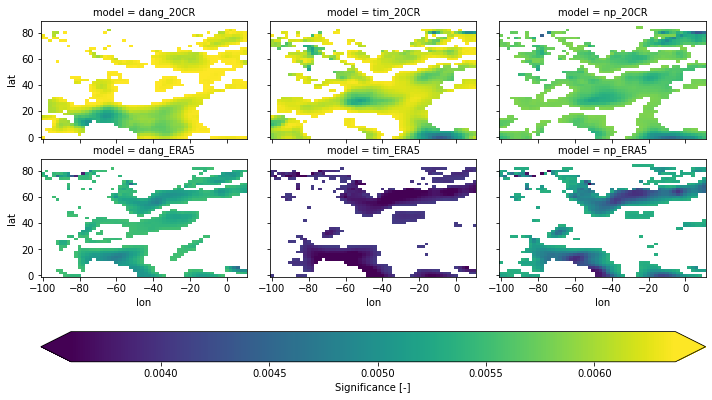

In [38]:
plot_all_models(SST_rmse,  'RMSE [m]', f'SST_sig_maps_{wind}')

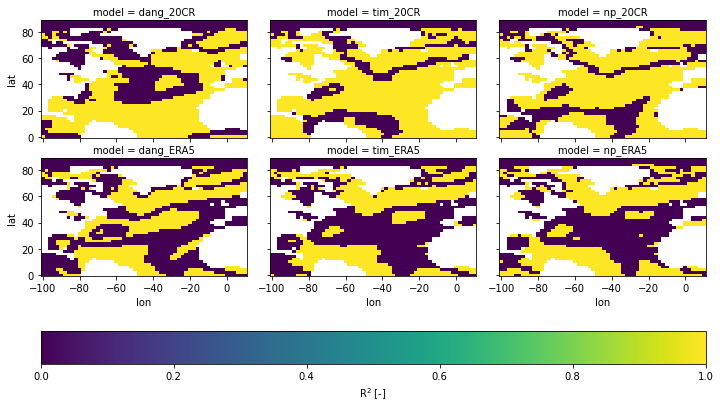

In [39]:
plot_all_models(SST_sig,  'R$^2$ [-]', f'SST_sig_maps_{wind}')

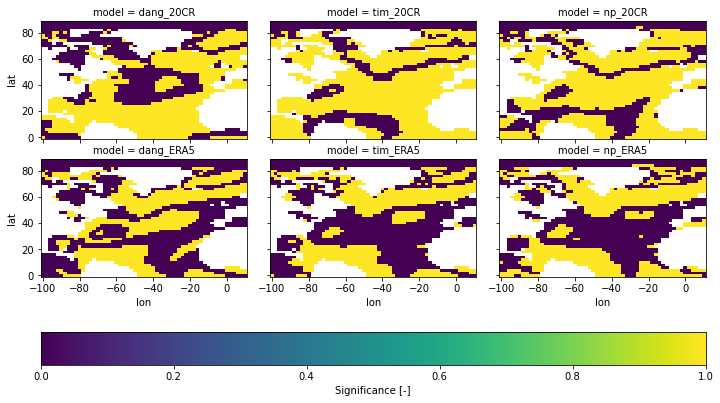

In [37]:
plot_all_models(SST_sig,  'Significance [-]', f'SST_sig_maps_{wind}')

In [40]:
# Create datasets
ts =xr.Dataset(data_vars=dict(wind1=(['year','lat','lon'], ts_lst2[0].transpose('year','lat','lon')),
                              wind2=(['year','lat','lon'], ts_lst2[1].transpose('year','lat','lon')),
                              wind3=(['year','lat','lon'], ts_lst2[2].transpose('year','lat','lon')),
                              wind4=(['year','lat','lon'], ts_lst2[3].transpose('year','lat','lon')),
                              wind5=(['year','lat','lon'], ts_lst2[4].transpose('year','lat','lon')),
                              wind6=(['year','lat','lon'], ts_lst2[5].transpose('year','lat','lon')),),
               coords=dict(year=ts_lst2[0].year,lat=ts_lst2[0].lat,lon=ts_lst2[0].lon,),
               attrs=dict(description="Timeseries resulting from regression"),)
SST_ts = ts.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
rmse = xr.Dataset(data_vars=dict(wind1=(['lat','lon'], rmse_lst2[0].transpose('lat','lon')),
                              wind2=(['lat','lon'], rmse_lst2[1].transpose('lat','lon')),
                              wind3=(['lat','lon'], rmse_lst2[2].transpose('lat','lon')),
                              wind4=(['lat','lon'], rmse_lst2[3].transpose('lat','lon')),
                              wind5=(['lat','lon'], rmse_lst2[4].transpose('lat','lon')),
                              wind6=(['lat','lon'], rmse_lst2[5].transpose('lat','lon')),),
               coords=dict(lat=rmse_lst2[0].lat,lon=rmse_lst2[0].lon,),
               attrs=dict(description="RMSE resulting from regression"),)
SST_rmse = rmse.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
r2 = xr.Dataset(data_vars=dict(wind1=(['lat','lon'], r2_lst2[0].transpose('lat','lon')),
                              wind2=(['lat','lon'], r2_lst2[1].transpose('lat','lon')),
                              wind3=(['lat','lon'], r2_lst2[2].transpose('lat','lon')),
                              wind4=(['lat','lon'], r2_lst2[3].transpose('lat','lon')),
                              wind5=(['lat','lon'], r2_lst2[4].transpose('lat','lon')),
                              wind6=(['lat','lon'], r2_lst2[5].transpose('lat','lon')),),
               coords=dict(lat=r2_lst2[0].lat,lon=r2_lst2[0].lon,),
               attrs=dict(description="R-squared resulting from regression"),)
SST_r2 = r2.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})

sig = xr.Dataset(data_vars=dict(wind1=(['lat','lon'], sig_lst2[0].transpose('lat','lon')),
                              wind2=(['lat','lon'], sig_lst2[1].transpose('lat','lon')),
                              wind3=(['lat','lon'], sig_lst2[2].transpose('lat','lon')),
                              wind4=(['lat','lon'], sig_lst2[3].transpose('lat','lon')),
                              wind5=(['lat','lon'], sig_lst2[4].transpose('lat','lon')),
                              wind6=(['lat','lon'], sig_lst2[5].transpose('lat','lon')),),
               coords=dict(lat=sig_lst2[0].lat,lon=sig_lst2[0].lon,),
               attrs=dict(description="Significance resulting from regression"),)
SST_sig = sig.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})



#### Plot RMSE

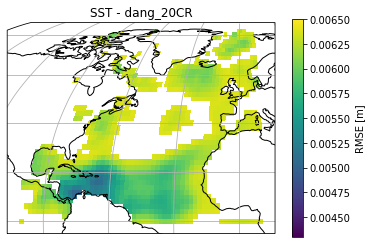

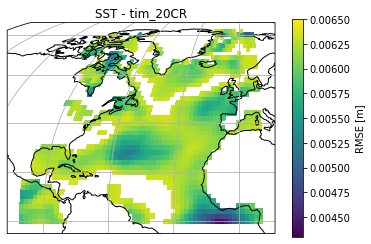

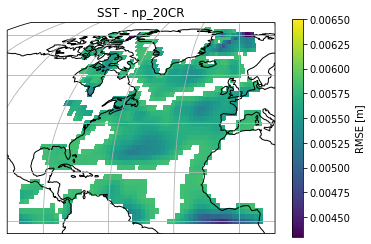

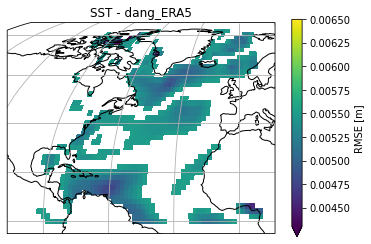

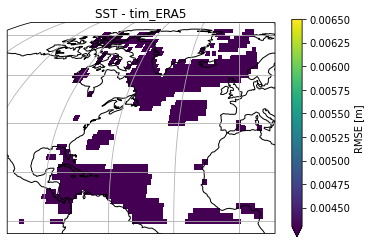

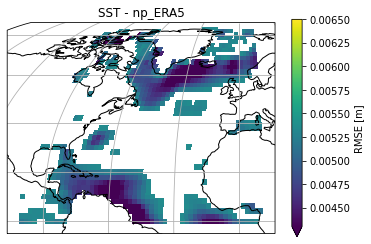

In [42]:
for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SST_rmse[name].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'RMSE [m]'},
                       vmin=0.0043, vmax = 0.0065)
    plt.title('SST - ' + name)
    plt.savefig(plot_path+'SST_rmse_map_'+name+'.png')
    

#### Plot R$^2$

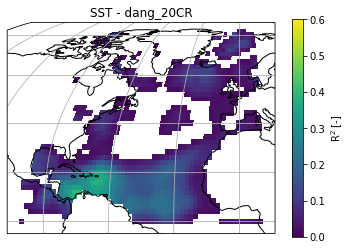

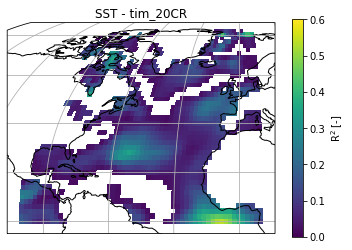

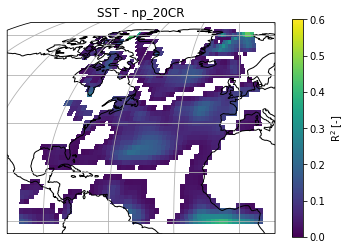

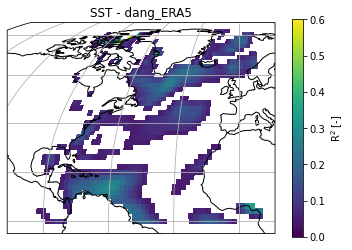

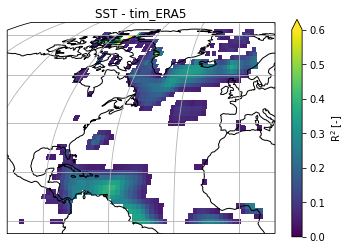

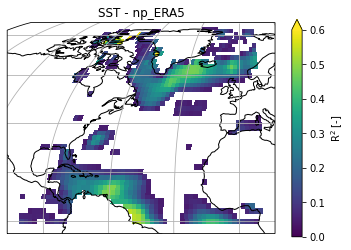

In [43]:
for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SST_r2[name].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'R$^2$ [-]'}, 
                      vmin = 0, vmax = 0.6)
    plt.title('SST - ' + name)
    plt.savefig(plot_path+'SST_r2_map_'+name+'.png')
 

#### Plot several timeseries

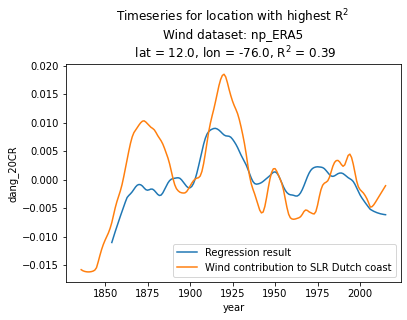

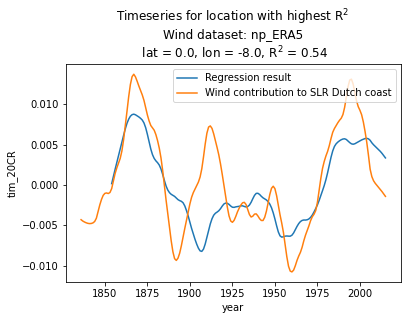

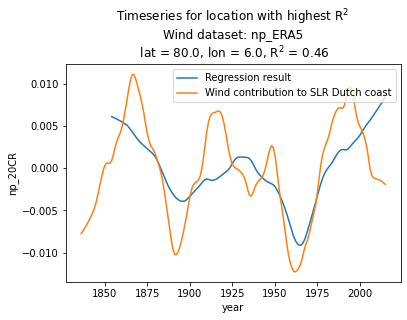

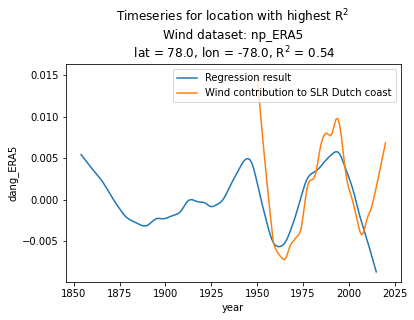

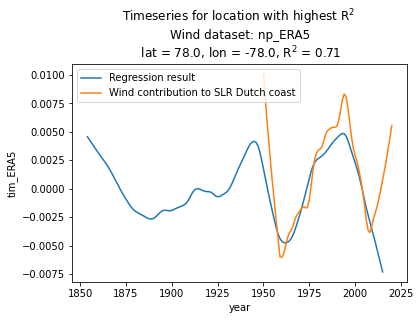

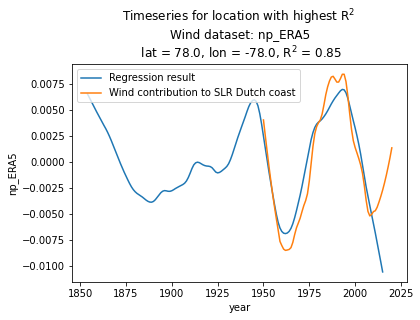

In [44]:
# Plot max R$^2$

for idx, wind in enumerate(wind_names):
    
    lat = SST_r2[wind].where(SST_r2[wind] == SST_r2[wind].max(), drop=True)['lat'].values[0]
    lon = SST_r2[wind].where(SST_r2[wind] == SST_r2[wind].max(), drop=True)['lon'].values[0]
    
    plt.figure()
    SST_ts[wind].sel(lat=lat,lon=lon,method='Nearest').plot(label = 'Regression result')
    plt.plot(wind_data[idx].index, wind_data[idx]['Average'], label = 'Wind contribution to SLR Dutch coast')
    plt.legend()
    plt.title('Timeseries for location with highest R$^2$ \n' + 'Wind dataset: ' + name + 
              '\n lat = '+str(lat)+', lon = '+str(lon) + ', R$^2$ = ' + 
              str(round(SST_r2[wind].where(SST_r2[wind] == SST_r2[wind].max(), drop=True).values[0][0],2)))
    plt.savefig(plot_path+'SST_ts_r2max_'+name+'.png', bbox_inches='tight')

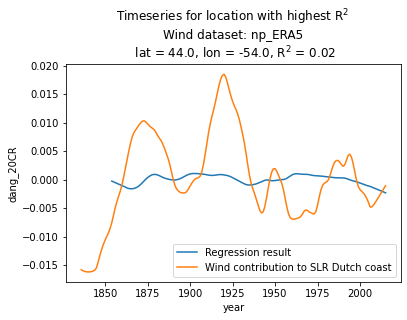

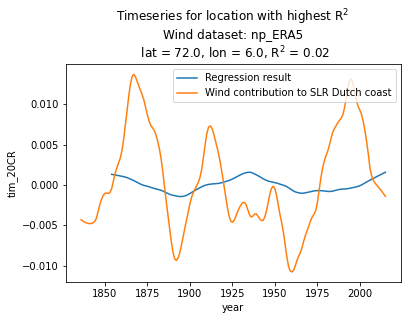

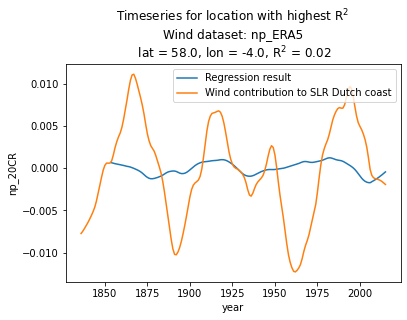

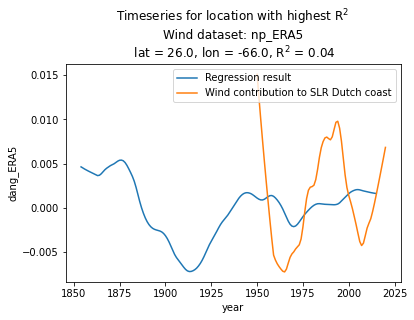

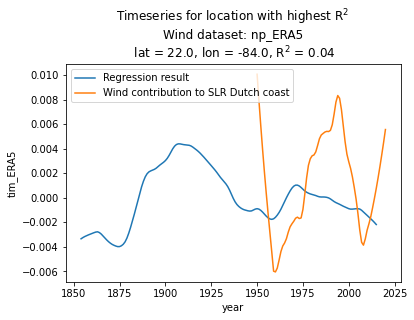

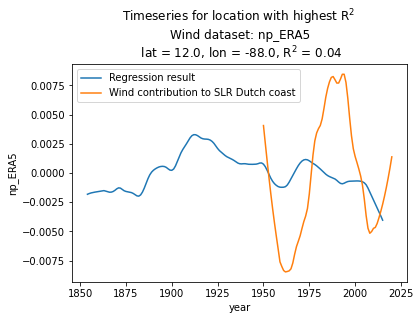

In [45]:
# Plot min R$^2$

for idx, wind in enumerate(wind_names):
    lat = SST_r2[wind].where(SST_r2[wind] == SST_r2[wind].min(), drop=True)['lat'].values[0]
    lon = SST_r2[wind].where(SST_r2[wind] == SST_r2[wind].min(), drop=True)['lon'].values[0]
    
    plt.figure()
    SST_ts[wind].sel(lat=lat,lon=lon,method='Nearest').plot(label = 'Regression result')
    plt.plot(wind_data[idx].index, wind_data[idx]['Average'], label = 'Wind contribution to SLR Dutch coast')
    plt.legend()
    plt.title('Timeseries for location with highest R$^2$ \n' + 'Wind dataset: ' + name + 
              '\n lat = '+str(lat)+', lon = '+str(lon) + ', R$^2$ = ' + 
              str(round(SST_r2[wind].where(SST_r2[wind] == SST_r2[wind].min(), drop=True).values[0][0],2)))
    plt.savefig(plot_path+'SST_ts_r2min_'+name+'.png', bbox_inches='tight')

### Perform regression with SKT

In [46]:
wind_names = ['dang_20CR', 'tim_20CR', 'np_20CR', 
              'dang_ERA5', 'tim_ERA5', 'np_ERA5']

ts_lst2, rmse_lst2, r2_lst2, sig_lst2 = [], [], [], []
for data_y in wind_data:
    ts_lst1, rmse_lst1, r2_lst1, sig_lst1 = [], [], [], []
    for lon in SKT_low.lon.values:
        ts_lst0, rmse_lst0, r2_lst0, sig_lst0 = [], [], [], []
        for lat in SKT_low.lat.values:
            ts, rmse, r2, sig = regression(SKT_low.sel(lat=lat, lon=lon, drop=True), data_y, 90)
            ts_lst0.append(ts)
            rmse_lst0.append(rmse)
            r2_lst0.append(r2)
            sig_lst0.append(sig)
        ts_lst1.append(xr.concat(ts_lst0, dim=SKT_low.lat.values).rename({"concat_dim":"lat"}))
        rmse_lst1.append(xr.DataArray(data=rmse_lst0 ,dims=["lat"],
                                      coords=dict(lat=SKT_low.lat.values,),))
        r2_lst1.append(xr.DataArray(data=r2_lst0 ,dims=["lat"],
                                      coords=dict(lat=SKT_low.lat.values,),))
        sig_lst1.append(xr.DataArray(data=sig_lst0 ,dims=["lat"],
                                      coords=dict(lat=SKT_low.lat.values,),))
    ts_lst2.append(xr.concat(ts_lst1, dim=SKT_low.lon.values).rename({"concat_dim":"lon"}))
    rmse_lst2.append(xr.concat(rmse_lst1, dim=SKT_low.lon.values).rename({"concat_dim":"lon"}))
    r2_lst2.append(xr.concat(r2_lst1, dim=SKT_low.lon.values).rename({"concat_dim":"lon"}))
    sig_lst2.append(xr.concat(sig_lst1, dim=SKT_low.lon.values).rename({"concat_dim":"lon"}))
            


In [47]:
SKT_ts0 = xr.concat(ts_lst2, dim=wind_names).rename({"concat_dim":"model"})
SKT_rmse0 = xr.concat(rmse_lst2, dim=wind_names).rename({"concat_dim":"model"})
SKT_r20 = xr.concat(r2_lst2, dim=wind_names).rename({"concat_dim":"model"})
SKT_sig0 = xr.concat(sig_lst2, dim=wind_names).rename({"concat_dim":"model"})

In [48]:
# Create datasets
ts =xr.Dataset(data_vars=dict(wind1=(['year','lat','lon'], ts_lst2[0].transpose('year','lat','lon')),
                              wind2=(['year','lat','lon'], ts_lst2[1].transpose('year','lat','lon')),
                              wind3=(['year','lat','lon'], ts_lst2[2].transpose('year','lat','lon')),
                              wind4=(['year','lat','lon'], ts_lst2[3].transpose('year','lat','lon')),
                              wind5=(['year','lat','lon'], ts_lst2[4].transpose('year','lat','lon')),
                              wind6=(['year','lat','lon'], ts_lst2[5].transpose('year','lat','lon')),),
               coords=dict(year=ts_lst2[0].year,lat=ts_lst2[0].lat,lon=ts_lst2[0].lon,),
               attrs=dict(description="Timeseries resulting from regression"),)
SKT_ts = ts.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
rmse = xr.Dataset(data_vars=dict(wind1=(['lat','lon'], rmse_lst2[0].transpose('lat','lon')),
                              wind2=(['lat','lon'], rmse_lst2[1].transpose('lat','lon')),
                              wind3=(['lat','lon'], rmse_lst2[2].transpose('lat','lon')),
                              wind4=(['lat','lon'], rmse_lst2[3].transpose('lat','lon')),
                              wind5=(['lat','lon'], rmse_lst2[4].transpose('lat','lon')),
                              wind6=(['lat','lon'], rmse_lst2[5].transpose('lat','lon')),),
               coords=dict(lat=rmse_lst2[0].lat,lon=rmse_lst2[0].lon,),
               attrs=dict(description="Timeseries resulting from regression"),)
SKT_rmse = rmse.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
r2 = xr.Dataset(data_vars=dict(wind1=(['lat','lon'], r2_lst2[0].transpose('lat','lon')),
                              wind2=(['lat','lon'], r2_lst2[1].transpose('lat','lon')),
                              wind3=(['lat','lon'], r2_lst2[2].transpose('lat','lon')),
                              wind4=(['lat','lon'], r2_lst2[3].transpose('lat','lon')),
                              wind5=(['lat','lon'], r2_lst2[4].transpose('lat','lon')),
                              wind6=(['lat','lon'], r2_lst2[5].transpose('lat','lon')),),
               coords=dict(lat=r2_lst2[0].lat,lon=r2_lst2[0].lon,),
               attrs=dict(description="Timeseries resulting from regression"),)
SKT_r2 = r2.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})

sig = xr.Dataset(data_vars=dict(wind1=(['lat','lon'], sig_lst2[0].transpose('lat','lon')),
                              wind2=(['lat','lon'], sig_lst2[1].transpose('lat','lon')),
                              wind3=(['lat','lon'], sig_lst2[2].transpose('lat','lon')),
                              wind4=(['lat','lon'], sig_lst2[3].transpose('lat','lon')),
                              wind5=(['lat','lon'], sig_lst2[4].transpose('lat','lon')),
                              wind6=(['lat','lon'], sig_lst2[5].transpose('lat','lon')),),
               coords=dict(lat=sig_lst2[0].lat,lon=sig_lst2[0].lon,),
               attrs=dict(description="Significance resulting from regression"),)
SKT_sig = sig.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})

#### Plot RMSE

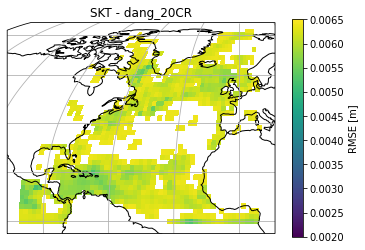

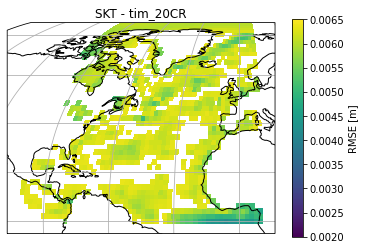

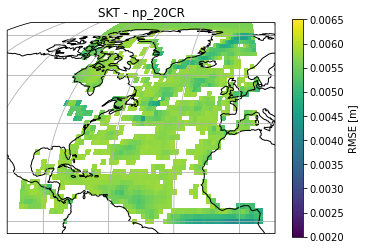

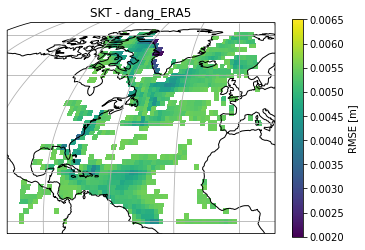

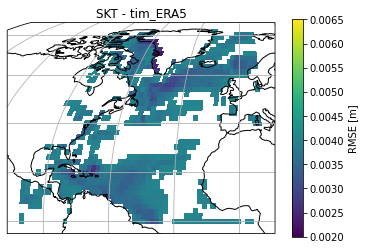

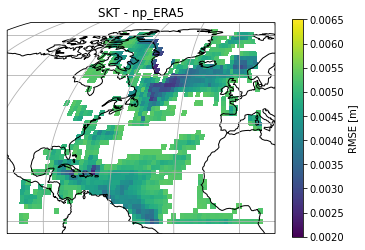

In [49]:
for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SKT_rmse[name].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'RMSE [m]'}, 
                      vmin = 0.002, vmax = 0.0065)
    plt.title('SKT - ' + name)
    plt.savefig(plot_path+'SKT_rmse_map_'+name+'.png', bbox_inches='tight')
 

#### Plot R$^2$

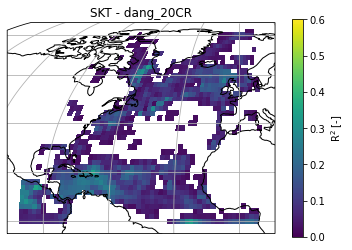

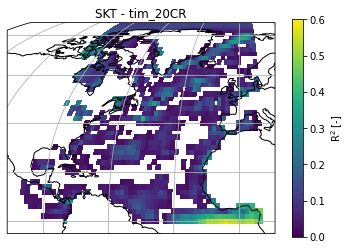

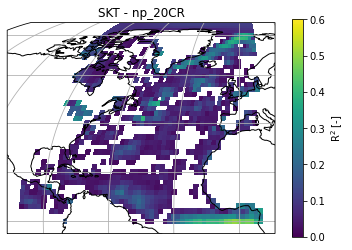

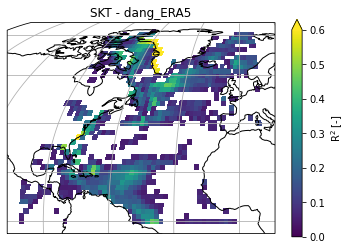

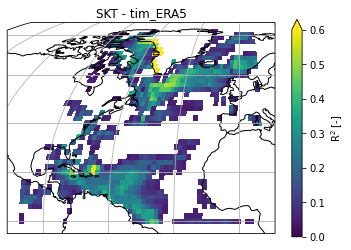

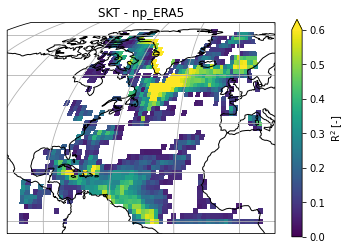

In [50]:
for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SKT_r2[name].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'R$^2$ [-]'}, 
                      vmin = 0, vmax = 0.6)
    plt.title('SKT - ' + name)
    plt.savefig(plot_path+'SKT_r2_map_'+name+'.png', bbox_inches='tight')
 

#### Plot several timeseries

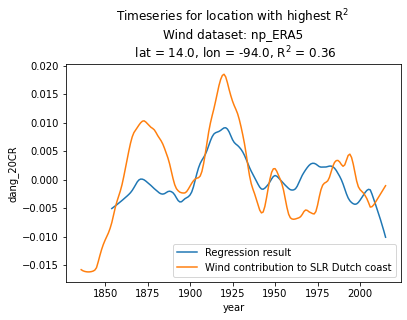

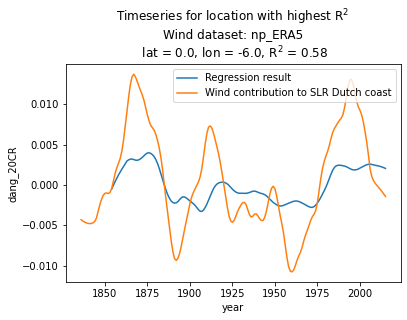

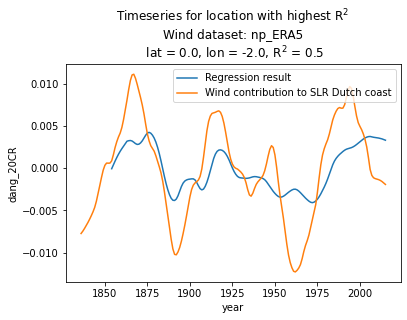

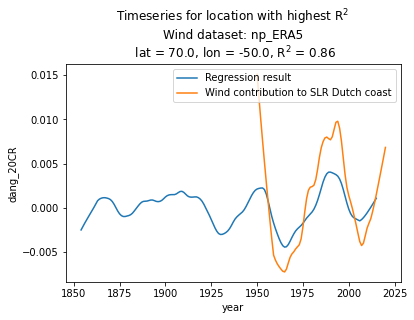

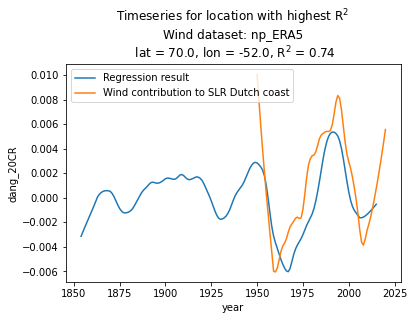

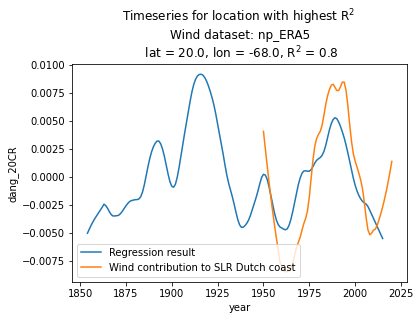

In [51]:
# Plot max R$^2$

for idx, wind in enumerate(wind_names):
    
    lat = SKT_r2[wind].where(SKT_r2[wind] == SKT_r2[wind].max(), drop=True)['lat'].values[0]
    lon = SKT_r2[wind].where(SKT_r2[wind] == SKT_r2[wind].max(), drop=True)['lon'].values[0]
    
    plt.figure()
    SKT_ts[wind_names[0]].sel(lat=lat,lon=lon,method='Nearest').plot(label = 'Regression result')
    plt.plot(wind_data[idx].index, wind_data[idx]['Average'], label = 'Wind contribution to SLR Dutch coast')
    plt.legend()
    plt.title('Timeseries for location with highest R$^2$ \n' + 'Wind dataset: ' + name + 
              '\n lat = '+str(lat)+', lon = '+str(lon) + ', R$^2$ = ' + 
              str(round(SKT_r2[wind].where(SKT_r2[wind] == SKT_r2[wind].max(), drop=True).values[0][0],2)))
    plt.savefig(plot_path+'SKT_ts_r2max_'+name+'.png', bbox_inches='tight')

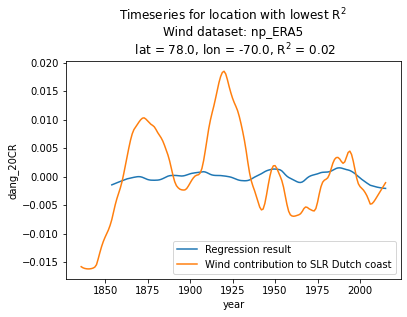

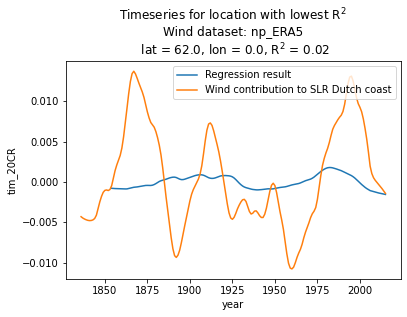

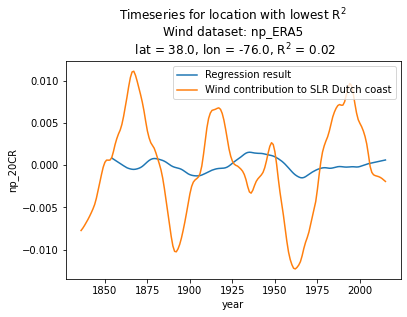

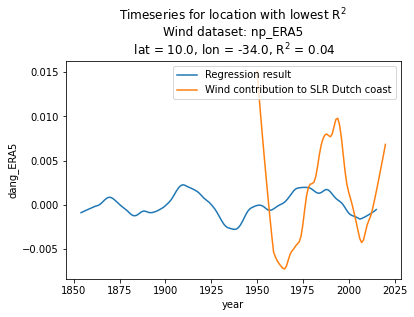

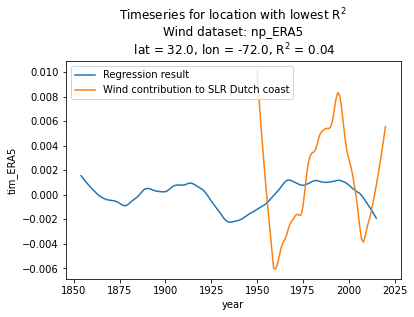

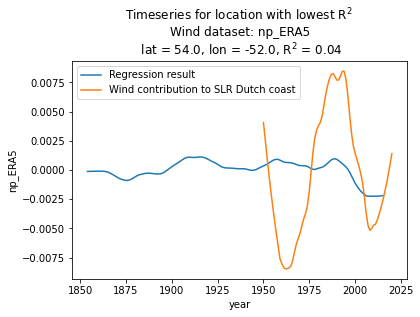

In [52]:
# Plot min R$^2$

for idx, wind in enumerate(wind_names):
    lat = SKT_r2[wind].where(SKT_r2[wind] == SKT_r2[wind].min(), drop=True)['lat'].values[0]
    lon = SKT_r2[wind].where(SKT_r2[wind] == SKT_r2[wind].min(), drop=True)['lon'].values[0]
    
    plt.figure()
    SKT_ts[wind].sel(lat=lat,lon=lon,method='Nearest').plot(label = 'Regression result')
    plt.plot(wind_data[idx].index, wind_data[idx]['Average'], label = 'Wind contribution to SLR Dutch coast')
    plt.legend()
    plt.title('Timeseries for location with lowest R$^2$ \n' + 'Wind dataset: ' + name + 
              '\n lat = '+str(lat)+', lon = '+str(lon) + ', R$^2$ = ' + 
              str(round(SKT_r2[wind].where(SKT_r2[wind] == SKT_r2[wind].min(), drop=True).values[0][0],2)))
    plt.savefig(plot_path+'SKT_ts_r2min_'+name+'.png', bbox_inches='tight')

### Perform lagged regression between wind contribution to sea level and sea temperatures

In [53]:
def regression(data_x, data_y, lag, significance_level):
    x_l = pd.DataFrame(data={'year': data_x.year, 'SST':data_x})
    x_l = x_l.set_index('year')
    x_l = x_l.shift(lag) # Execute lagged regression by shifting the AMV dataframe. 
    x_l = x_l.dropna()
    
    if x_l.size == 0: return data_x.reset_coords('degree', drop=True), np.nan, np.nan
    
    y_l = copy.deepcopy(data_y['Average'])
        
    # Standardize x
    scaler = StandardScaler()
    x_l = copy.deepcopy(x_l)
    x_l.iloc[:,:] = scaler.fit_transform(x_l)
        
    # Create dataseries of equal time span
    y = y_l[y_l.index.isin(x_l.index)]
    x = x_l[x_l.index.isin(y.index)]

    # Fit the regression model
    linear_regression = linr()
    fit = linear_regression.fit(x, y)
    r2 = linear_regression.score(x, y)
    intercept = linear_regression.intercept_
    coefs = linear_regression.coef_.tolist()[0]
    timeseries = coefs*x_l['SST']
    SST_reg_timeseries = xr.DataArray(data=timeseries ,dims=["year"],
                                      coords=dict(year=timeseries.index.values,),)
        
    yhat = linear_regression.predict(x)
    mse = mean_squared_error(y, yhat) # Calculate insample mse (non-negative)
    rmse = np.sqrt(mse)
    f_statistic, p_values = f_regression(x, y)
    
    # Check significance
    significance = significance_test(p_values[0], 1-significance_level/100)
    
    if significance == False:
        r2 = np.nan
        rmse =  np.nan
        
        
    return SST_reg_timeseries, rmse, r2

#### Perform lagged regression for SST

In [54]:
wind_names = ['dang_20CR', 'tim_20CR', 'np_20CR', 
              'dang_ERA5', 'tim_ERA5', 'np_ERA5']
lags = [-20, -15, -10, -5, 0]

ts_lst3, rmse_lst3, r2_lst3 = [], [], []

for data_y in wind_data:
    ts_lst2, rmse_lst2, r2_lst2 = [], [], []
    
    for lon in SST_low.lon.values:
        ts_lst1, rmse_lst1, r2_lst1 = [], [], []
        
        for lat in SST_low.lat.values:
            ts_lst0, rmse_lst0, r2_lst0 = [], [], []
            
            for lag in lags:
                ts, rmse, r2 = regression(SST_low.sel(lat=lat, lon=lon, drop=True), data_y, lag, 90)
                ts_lst0.append(ts)
                rmse_lst0.append(rmse)
                r2_lst0.append(r2)
            
            ts_lst1.append(xr.concat(ts_lst0, dim=lags).rename({"concat_dim":"lag"}))
            rmse_lst1.append(xr.DataArray(data=rmse_lst0 ,dims=["lag"],
                                          coords=dict(lag=lags,),))
            r2_lst1.append(xr.DataArray(data=r2_lst0 ,dims=["lag"],
                                          coords=dict(lag=lags,),))
        
                
        ts_lst2.append(xr.concat(ts_lst1, dim=SST_low.lat.values).rename({"concat_dim":"lat"}))
        rmse_lst2.append(xr.concat(rmse_lst1, dim=SST_low.lat.values).rename({"concat_dim":"lat"}))
        r2_lst2.append(xr.concat(r2_lst1, dim=SST_low.lat.values).rename({"concat_dim":"lat"}))
        
    ts_lst3.append(xr.concat(ts_lst2, dim=SST_low.lon.values).rename({"concat_dim":"lon"}))
    rmse_lst3.append(xr.concat(rmse_lst2, dim=SST_low.lon.values).rename({"concat_dim":"lon"}))
    r2_lst3.append(xr.concat(r2_lst2, dim=SST_low.lon.values).rename({"concat_dim":"lon"}))
            
SST_lag_ts0 = xr.concat(ts_lst3, dim=wind_names).rename({"concat_dim":"model"})
SST_lag_rmse0 = xr.concat(rmse_lst3, dim=wind_names).rename({"concat_dim":"model"})
SST_lag_r20 = xr.concat(r2_lst3, dim=wind_names).rename({"concat_dim":"model"})


In [55]:
# Create datasets
ts =xr.Dataset(data_vars=dict(wind1=(['year','lat','lon','lag'], ts_lst3[0].transpose('year','lat','lon','lag')),
                              wind2=(['year','lat','lon','lag'], ts_lst3[1].transpose('year','lat','lon','lag')),
                              wind3=(['year','lat','lon','lag'], ts_lst3[2].transpose('year','lat','lon','lag')),
                              wind4=(['year','lat','lon','lag'], ts_lst3[3].transpose('year','lat','lon','lag')),
                              wind5=(['year','lat','lon','lag'], ts_lst3[4].transpose('year','lat','lon','lag')),
                              wind6=(['year','lat','lon','lag'], ts_lst3[5].transpose('year','lat','lon','lag')),),
               coords=dict(year=ts_lst3[0].year,lat=ts_lst3[0].lat,lon=ts_lst3[0].lon,lag=lags,),
               attrs=dict(description="Timeseries resulting from regression"),)
SST_lag_ts = ts.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
rmse = xr.Dataset(data_vars=dict(wind1=(['lat','lon', 'lag'], rmse_lst3[0].transpose('lat','lon','lag')),
                              wind2=(['lat','lon','lag'], rmse_lst3[1].transpose('lat','lon','lag')),
                              wind3=(['lat','lon','lag'], rmse_lst3[2].transpose('lat','lon','lag')),
                              wind4=(['lat','lon','lag'], rmse_lst3[3].transpose('lat','lon','lag')),
                              wind5=(['lat','lon','lag'], rmse_lst3[4].transpose('lat','lon','lag')),
                              wind6=(['lat','lon','lag'], rmse_lst3[5].transpose('lat','lon','lag')),),
               coords=dict(lat=rmse_lst3[0].lat,lon=rmse_lst3[0].lon,lag=lags,),
               attrs=dict(description="Timeseries resulting from lagged regression"),)
SST_lag_rmse = rmse.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
r2 = xr.Dataset(data_vars=dict(wind1=(['lat','lon','lag'], r2_lst3[0].transpose('lat','lon','lag')),
                              wind2=(['lat','lon','lag'], r2_lst3[1].transpose('lat','lon','lag')),
                              wind3=(['lat','lon','lag'], r2_lst3[2].transpose('lat','lon','lag')),
                              wind4=(['lat','lon','lag'], r2_lst3[3].transpose('lat','lon','lag')),
                              wind5=(['lat','lon','lag'], r2_lst3[4].transpose('lat','lon','lag')),
                              wind6=(['lat','lon','lag'], r2_lst3[5].transpose('lat','lon','lag')),),
               coords=dict(lat=r2_lst3[0].lat,lon=r2_lst3[0].lon,lag=lags,),
               attrs=dict(description="Timeseries resulting from lagged regression"),)
SST_lag_r2 = r2.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})



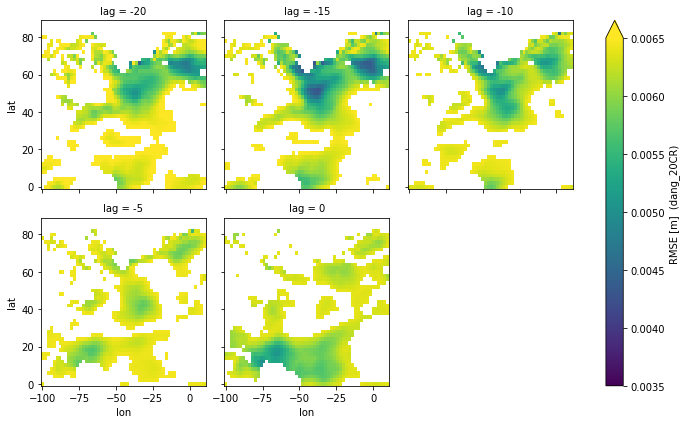

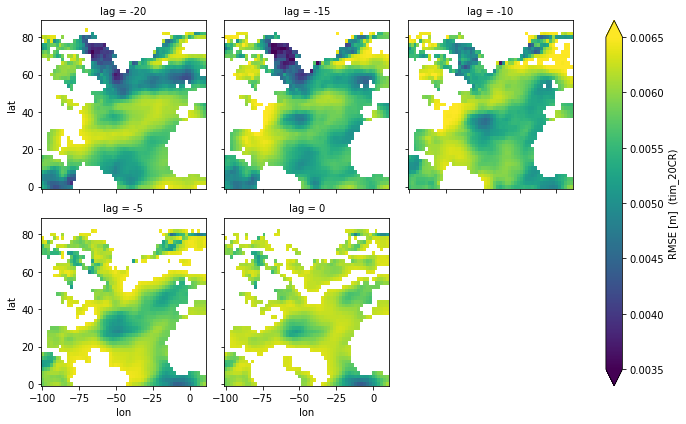

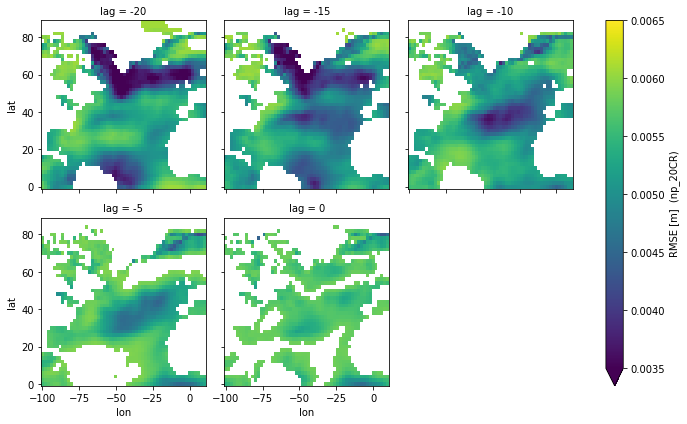

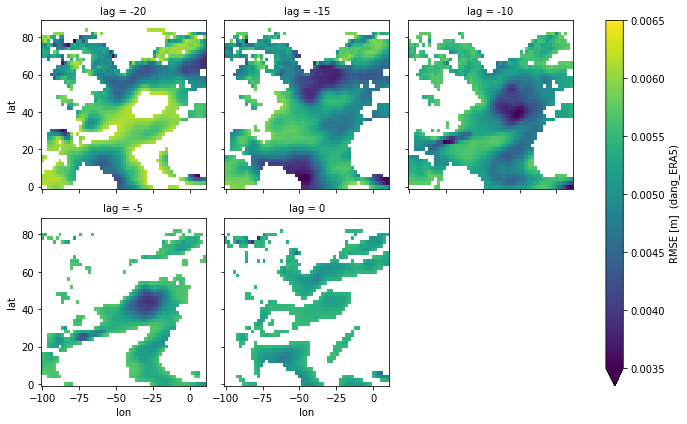

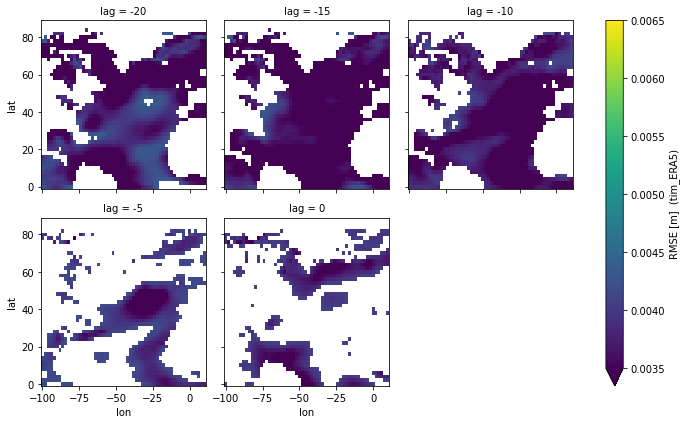

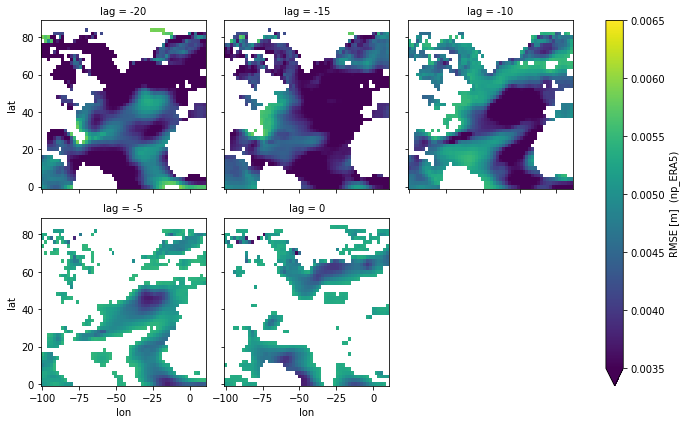

In [56]:
for name in wind_names:
    
    SST_lag_rmse[name].plot(col='lag', col_wrap=3,
                            cbar_kwargs={'label':'RMSE [m]  ('+name+')'}, 
                            vmin = 0.0035, vmax = 0.0065)
    plt.savefig(plot_path+'SST_rmse_all_lags_map_'+name+'.png', bbox_inches='tight')
 


In [68]:
def plot_all_models_lag(data, lag, name):
    cbar_kwargs = {'orientation': 'horizontal','label': f'R$^2$ [-] (lag = {lag})'}
    fg = data.plot(x='lon', y='lat', col='model', col_wrap=3, robust=True, transform=ccrs.PlateCarree(),
              cbar_kwargs=cbar_kwargs,
              subplot_kws={"projection": ccrs.Robinson()},
             vmin=-0.8,  vmax=0.8)
    fg.map(lambda: plt.gca().coastlines())
    plt.tight_layout()
    plt.savefig(plot_path+f'{name}_r2_{lag}.png', bbox_inches='tight')

<ipython-input-68-eb5370cea5a8>:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-68-eb5370cea5a8>:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


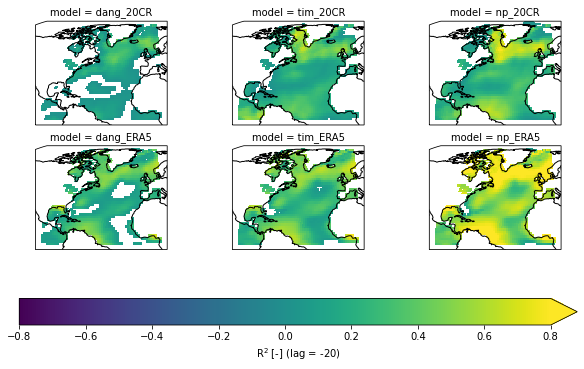

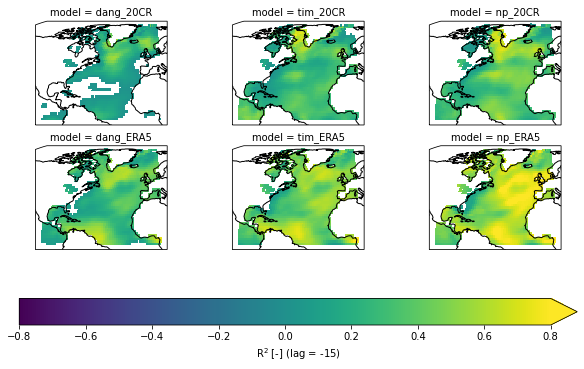

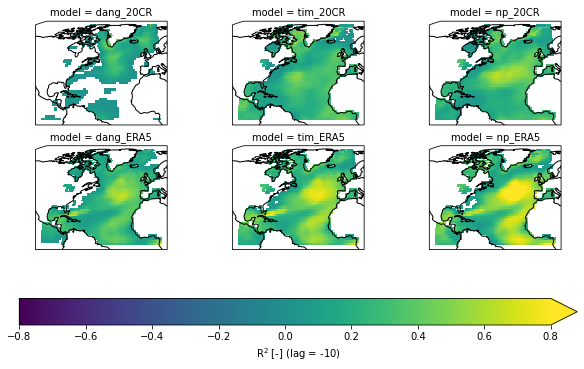

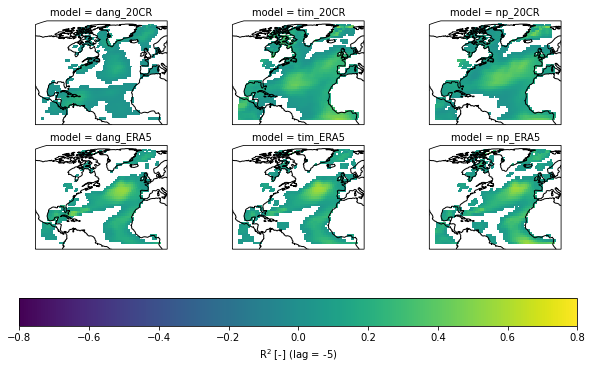

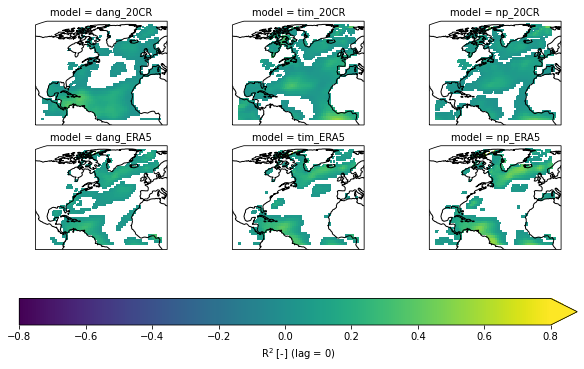

In [70]:
for lag in SST_lag_r20.lag.values:
    plot_all_models_lag(SST_lag_r20.sel(lag=lag), lag, 'SST')

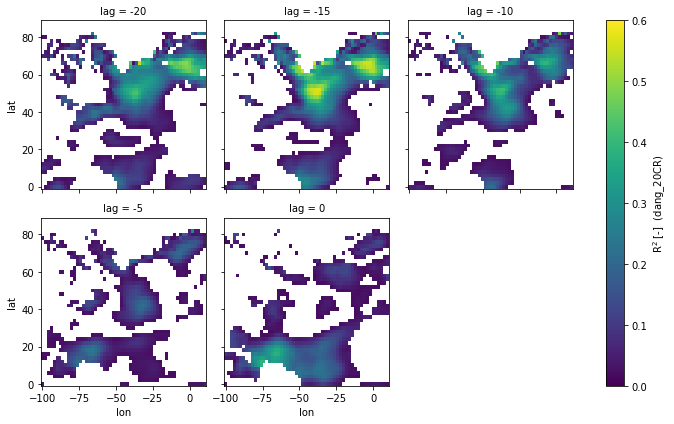

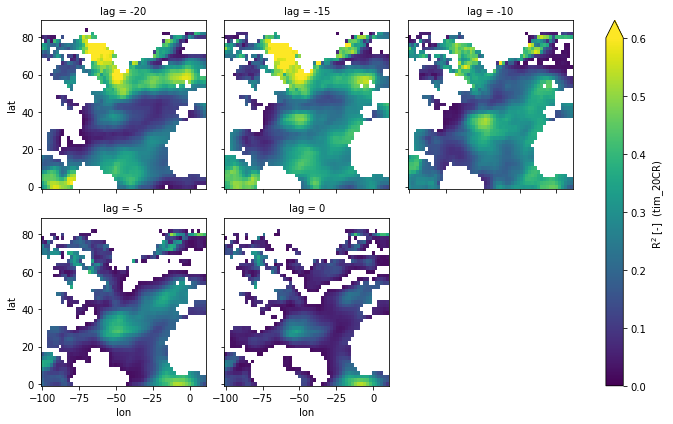

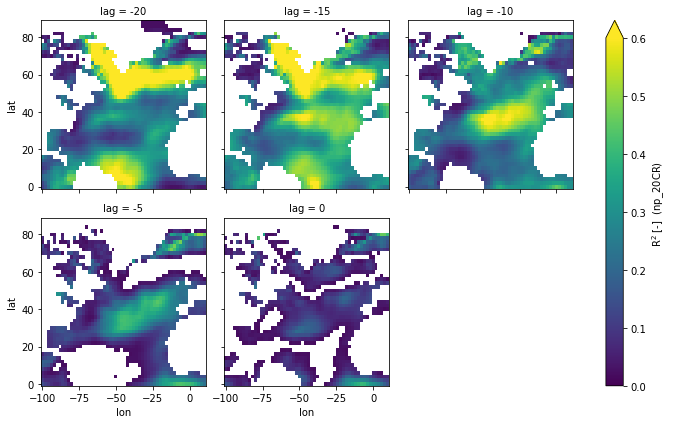

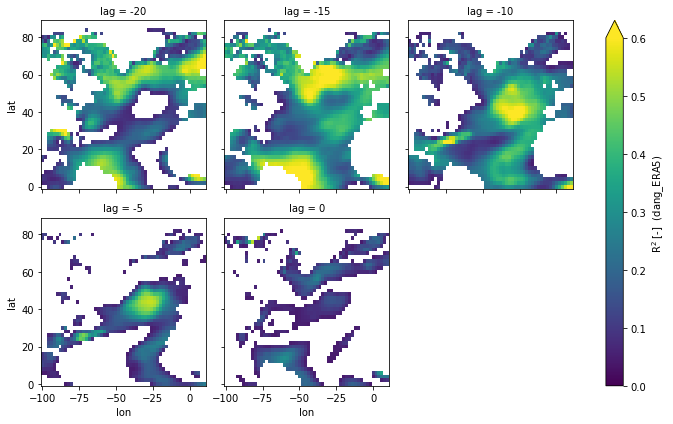

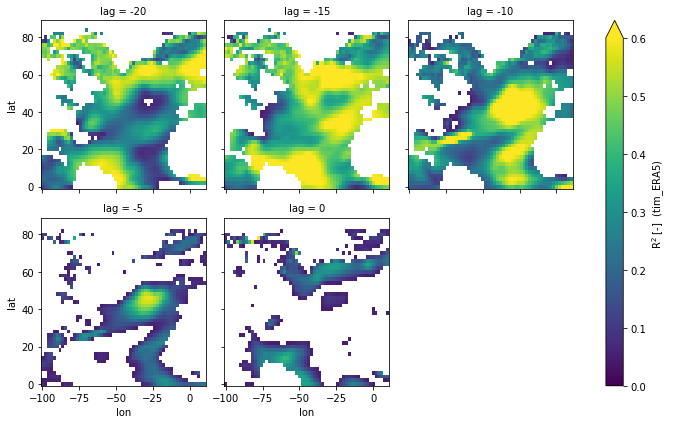

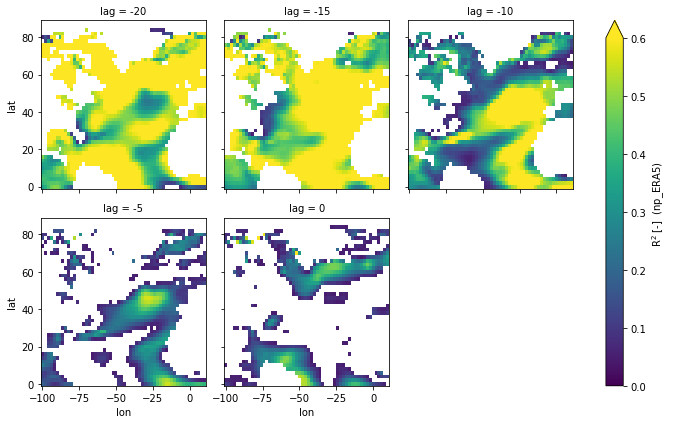

In [57]:
for name in wind_names:
    cbar_kwargs = {'orientation': 'horizontal','label': f'Corr coef [-] (lag = {lag})'}
    SST_lag_r2[name].plot(col='lag', col_wrap=3,
                            cbar_kwargs={'label':'R$^2$ [-]  ('+name+')'},
                         vmin=0, vmax=0.6)
    plt.savefig(plot_path+'SST_r2_all_lags_map_'+name+'.png', bbox_inches='tight')
 

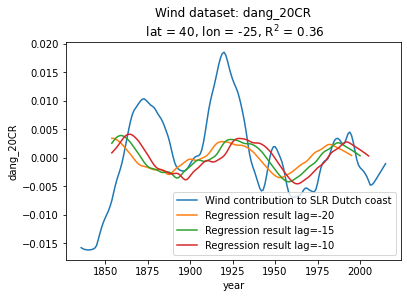

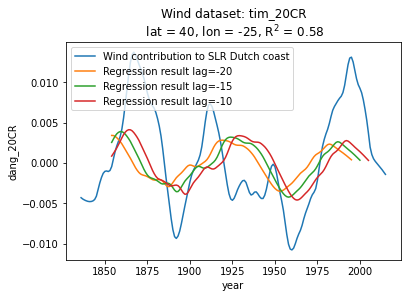

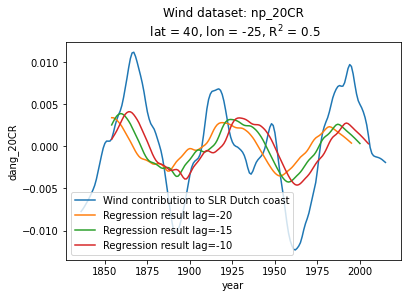

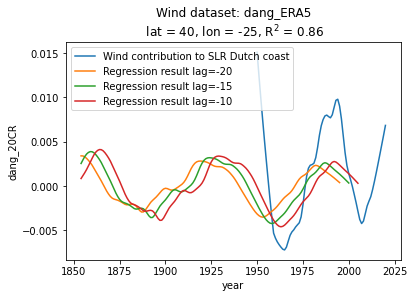

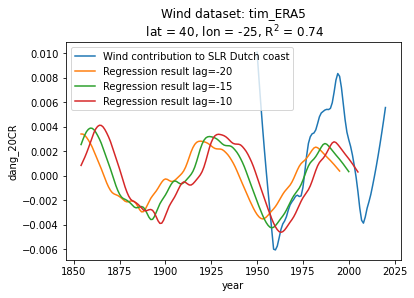

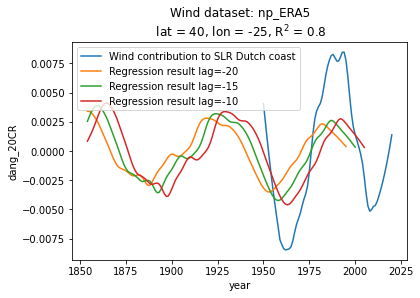

In [58]:
# Plot timeseries
lags2 = [-20, -15, -10]
for idx, wind in enumerate(wind_names):
    
    lat = 40
    lon = -25
    
    plt.figure()
    plt.plot(wind_data[idx].index, wind_data[idx]['Average'], label = 'Wind contribution to SLR Dutch coast')
    for lag in lags2:
        SST_lag_ts[wind_names[0]].sel(lat=lat,lon=lon,lag=lag, method='Nearest').plot(
            label = 'Regression result lag='+str(lag))
    plt.legend()
    plt.title('Wind dataset: ' + wind + 
              '\n lat = '+str(lat)+', lon = '+str(lon) + ', R$^2$ = ' + 
              str(round(SKT_r2[wind].where(SKT_r2[wind] == SKT_r2[wind].max(), drop=True).values[0][0],2)))
    plt.savefig(plot_path+'SST_lag_ts_lat40_lonmin25_'+name+'.png', bbox_inches='tight')

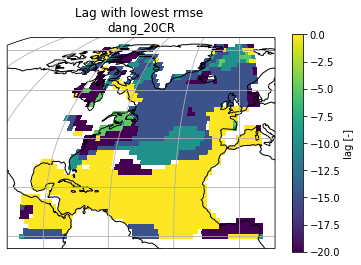

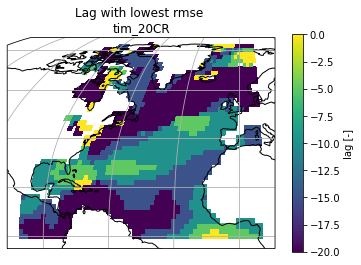

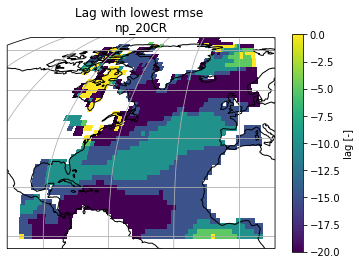

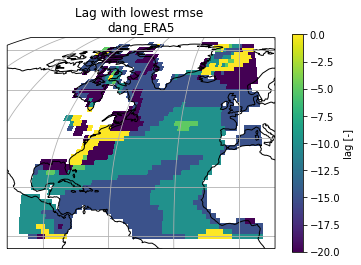

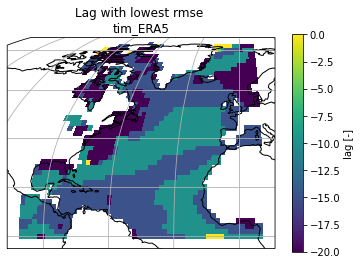

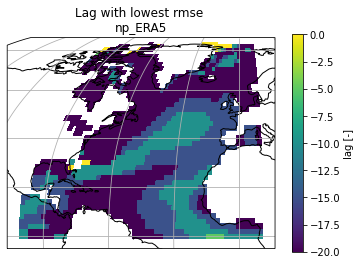

In [59]:
# Create array of lags with minimum rmse
SST_best_lag = SST_lag_rmse.idxmin('lag')

#Plot

for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SST_best_lag[name].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'lag [-]'})
    plt.title('Lag with lowest rmse \n' + name)
    plt.savefig(plot_path+'SST_bestlag_map_'+name+'.png', bbox_inches='tight')
 

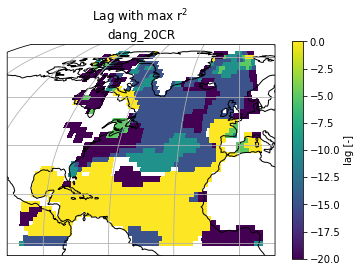

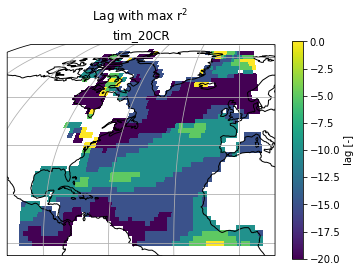

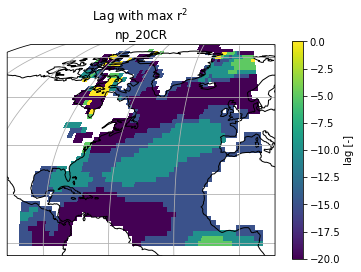

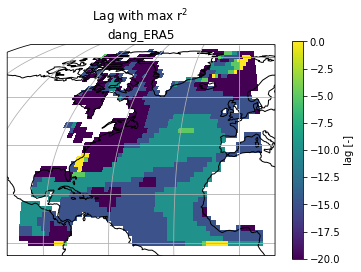

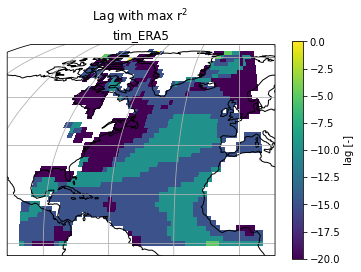

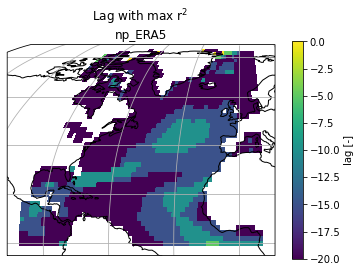

In [60]:
# Create array of lags with maximum r2
SST_best_lag_r2 = SST_lag_r2.idxmax('lag')

#Plot

for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SST_best_lag_r2[name].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'lag [-]'})
    plt.title('Lag with max r$^2$ \n' + name)
    plt.savefig(plot_path+'SST_bestlag_r2_map_'+name+'.png', bbox_inches='tight')
 

Since -15 has smallest rmse and highest r$^2$, plot map of R$^2$ values for a lag of -15

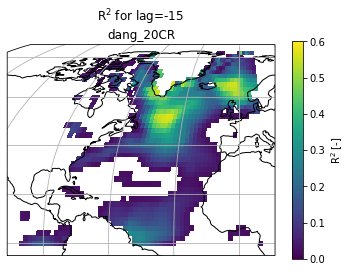

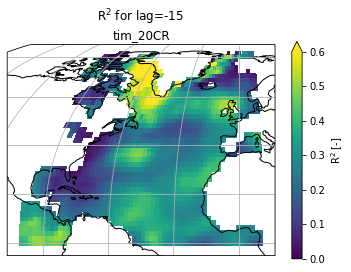

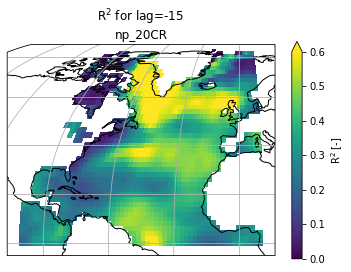

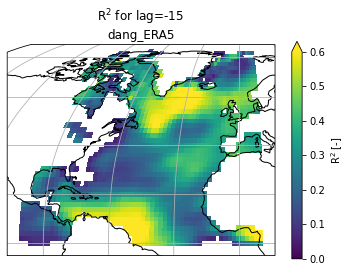

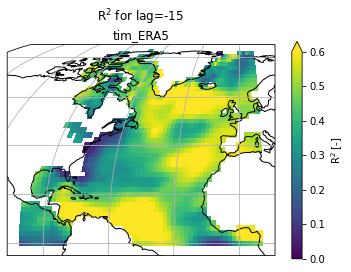

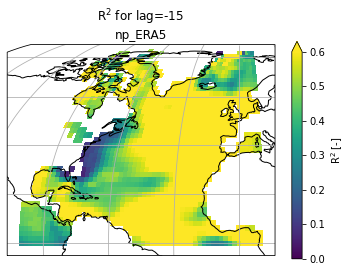

In [61]:
#Plot R2 for lag = -15

for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SST_lag_r2[name].sel(lag=-15).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'R$^2$ [-]'}, vmin = 0, vmax = 0.6)
    plt.title('R$^2$ for lag=-15 \n' + name)
    plt.savefig(plot_path+'SST_R2_lagmin15_map_'+name+'.png', bbox_inches='tight')
  

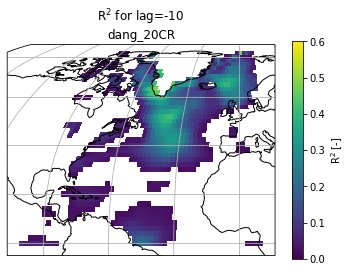

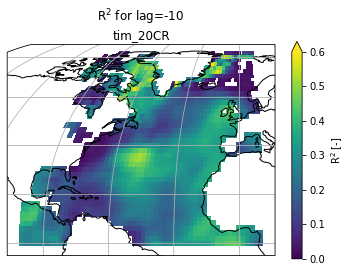

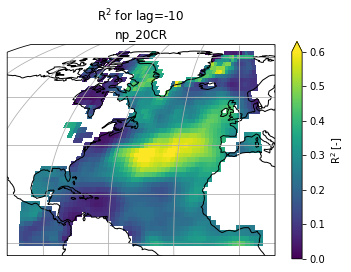

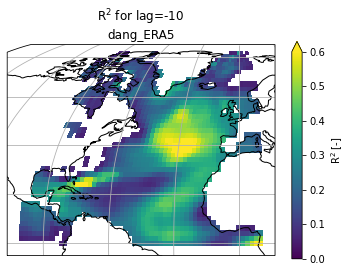

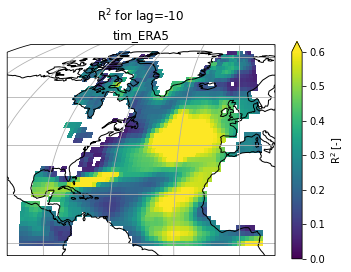

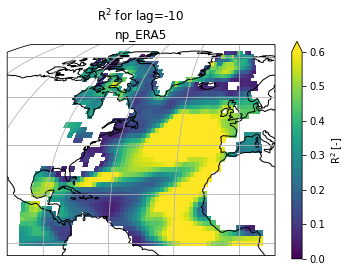

In [62]:
#Plot R2 for lag = -10

for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SST_lag_r2[name].sel(lag=-10).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'R$^2$ [-]'}, vmin = 0, vmax = 0.6)
    plt.title('R$^2$ for lag=-10 \n' + name)
    plt.savefig(plot_path+'SST_R2_lagmin10_map_'+name+'.png', bbox_inches='tight')
  

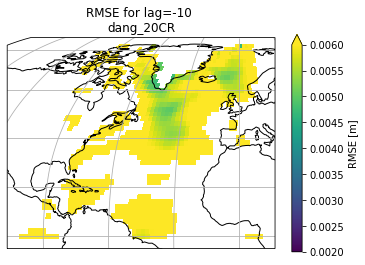

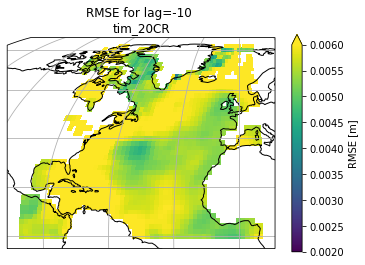

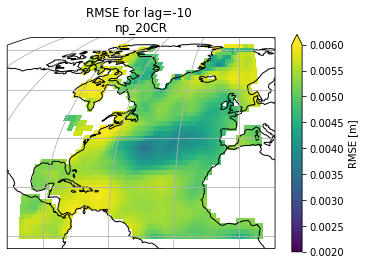

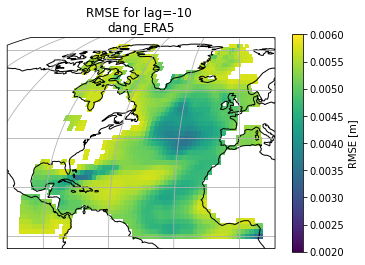

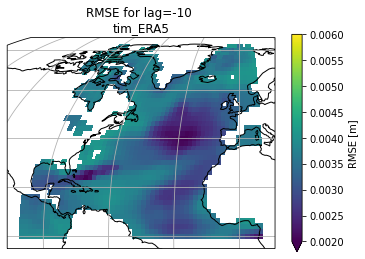

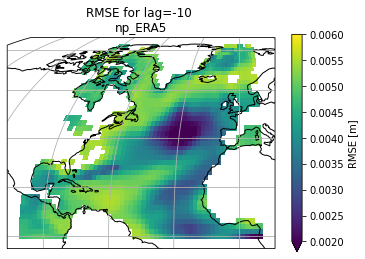

In [63]:
#Plot RMSE for lag = -10
for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SST_lag_rmse[name].sel(lag=-10).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'RMSE [m]'}, vmin = 0.002, vmax = 0.006)
    plt.title('RMSE for lag=-10 \n' + name)
    plt.savefig(plot_path+'SST_RMSE_lagmin10_map_'+name+'.png', bbox_inches='tight')

#### Perform lagged regression for SKT

In [64]:
wind_names = ['dang_20CR', 'tim_20CR', 'np_20CR', 
              'dang_ERA5', 'tim_ERA5', 'np_ERA5']
lags = [-20, -15, -10, -5, 0]

ts_lst3, rmse_lst3, r2_lst3 = [], [], []

for data_y in wind_data:
    ts_lst2, rmse_lst2, r2_lst2 = [], [], []
    
    for lon in SKT_low.lon.values:
        ts_lst1, rmse_lst1, r2_lst1 = [], [], []
        
        for lat in SKT_low.lat.values:
            ts_lst0, rmse_lst0, r2_lst0 = [], [], []
            
            for lag in lags:
                ts, rmse, r2 = regression(SKT_low.sel(lat=lat, lon=lon, drop=True), data_y, lag, 90)
                ts_lst0.append(ts)
                rmse_lst0.append(rmse)
                r2_lst0.append(r2)
            
            ts_lst1.append(xr.concat(ts_lst0, dim=lags).rename({"concat_dim":"lag"}))
            rmse_lst1.append(xr.DataArray(data=rmse_lst0 ,dims=["lag"],
                                          coords=dict(lag=lags,),))
            r2_lst1.append(xr.DataArray(data=r2_lst0 ,dims=["lag"],
                                          coords=dict(lag=lags,),))
        
                
        ts_lst2.append(xr.concat(ts_lst1, dim=SKT_low.lat.values).rename({"concat_dim":"lat"}))
        rmse_lst2.append(xr.concat(rmse_lst1, dim=SKT_low.lat.values).rename({"concat_dim":"lat"}))
        r2_lst2.append(xr.concat(r2_lst1, dim=SKT_low.lat.values).rename({"concat_dim":"lat"}))
        
    ts_lst3.append(xr.concat(ts_lst2, dim=SKT_low.lon.values).rename({"concat_dim":"lon"}))
    rmse_lst3.append(xr.concat(rmse_lst2, dim=SKT_low.lon.values).rename({"concat_dim":"lon"}))
    r2_lst3.append(xr.concat(r2_lst2, dim=SKT_low.lon.values).rename({"concat_dim":"lon"}))
            
SKT_lag_ts0 = xr.concat(ts_lst3, dim=wind_names).rename({"concat_dim":"model"})
SKT_lag_rmse0 = xr.concat(rmse_lst3, dim=wind_names).rename({"concat_dim":"model"})
SKT_lag_r20 = xr.concat(r2_lst3, dim=wind_names).rename({"concat_dim":"model"})   


KeyboardInterrupt: 

In [ ]:
# Create datasets
ts =xr.Dataset(data_vars=dict(wind1=(['year','lat','lon','lag'], ts_lst3[0].transpose('year','lat','lon','lag')),
                              wind2=(['year','lat','lon','lag'], ts_lst3[1].transpose('year','lat','lon','lag')),
                              wind3=(['year','lat','lon','lag'], ts_lst3[2].transpose('year','lat','lon','lag')),
                              wind4=(['year','lat','lon','lag'], ts_lst3[3].transpose('year','lat','lon','lag')),
                              wind5=(['year','lat','lon','lag'], ts_lst3[4].transpose('year','lat','lon','lag')),
                              wind6=(['year','lat','lon','lag'], ts_lst3[5].transpose('year','lat','lon','lag')),),
               coords=dict(year=ts_lst3[0].year,lat=ts_lst3[0].lat,lon=ts_lst3[0].lon,lag=lags,),
               attrs=dict(description="Timeseries resulting from regression"),)
SKT_lag_ts = ts.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
rmse = xr.Dataset(data_vars=dict(wind1=(['lat','lon', 'lag'], rmse_lst3[0].transpose('lat','lon','lag')),
                              wind2=(['lat','lon','lag'], rmse_lst3[1].transpose('lat','lon','lag')),
                              wind3=(['lat','lon','lag'], rmse_lst3[2].transpose('lat','lon','lag')),
                              wind4=(['lat','lon','lag'], rmse_lst3[3].transpose('lat','lon','lag')),
                              wind5=(['lat','lon','lag'], rmse_lst3[4].transpose('lat','lon','lag')),
                              wind6=(['lat','lon','lag'], rmse_lst3[5].transpose('lat','lon','lag')),),
               coords=dict(lat=rmse_lst3[0].lat,lon=rmse_lst3[0].lon,lag=lags,),
               attrs=dict(description="Timeseries resulting from lagged regression"),)
SKT_lag_rmse = rmse.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
r2 = xr.Dataset(data_vars=dict(wind1=(['lat','lon','lag'], r2_lst3[0].transpose('lat','lon','lag')),
                              wind2=(['lat','lon','lag'], r2_lst3[1].transpose('lat','lon','lag')),
                              wind3=(['lat','lon','lag'], r2_lst3[2].transpose('lat','lon','lag')),
                              wind4=(['lat','lon','lag'], r2_lst3[3].transpose('lat','lon','lag')),
                              wind5=(['lat','lon','lag'], r2_lst3[4].transpose('lat','lon','lag')),
                              wind6=(['lat','lon','lag'], r2_lst3[5].transpose('lat','lon','lag')),),
               coords=dict(lat=r2_lst3[0].lat,lon=r2_lst3[0].lon,lag=lags,),
               attrs=dict(description="Timeseries resulting from lagged regression"),)
SKT_lag_r2 = r2.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})



In [ ]:
for name in wind_names:
    SKT_lag_rmse[name].plot(col='lag', col_wrap=3,
                            cbar_kwargs={'label':'RMSE [m]  ('+name+')'}, 
                            vmin = 0.0035, vmax = 0.0065)
    plt.savefig(plot_path+'SKT_rmse_all_lags_map_'+name+'.png', bbox_inches='tight')
 


In [ ]:
for name in wind_names:
    SKT_lag_r2[name].plot(col='lag', col_wrap=3,
                            cbar_kwargs={'label':'R$^2$ [-]  ('+name+')'},
                         vmin=0, vmax=0.6)
    plt.savefig(plot_path+'SKT_r2_all_lags_map_'+name+'.png', bbox_inches='tight')
 

In [ ]:
# Plot timeseries
lags2 = [-20, -15, -10, 20]
for idx, wind in enumerate(wind_names):
    
    lat = 40
    lon = -25
    
    plt.figure()
    plt.plot(wind_data[idx].index, wind_data[idx]['Average'], label = 'Wind contribution to SLR Dutch coast')
    for lag in lags2:
        SKT_lag_ts[wind_names[0]].sel(lat=lat,lon=lon,lag=lag, method='Nearest').plot(
            label = 'Regression result lag='+str(lag))
    plt.legend()
    plt.title('Wind dataset: ' + wind + 
              '\n lat = '+str(lat)+', lon = '+str(lon) + ', R$^2$ = ' + 
              str(round(SKT_r2[wind].where(SKT_r2[wind] == SKT_r2[wind].max(), drop=True).values[0][0],2)))
    plt.savefig(plot_path+'SKT_lag_ts_lat40_lonmin25_'+name+'.png', bbox_inches='tight')

In [ ]:
# Create array of lags with minimum rmse
SKT_best_lag = SKT_lag_rmse.idxmin('lag')

#Plot

for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SKT_best_lag[name].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'lag [-]'})
    plt.title('Lag with lowest rmse \n' + name)
    plt.savefig(plot_path+'SKT_bestlag_map_'+name+'.png', bbox_inches='tight')
 

In [ ]:
# Create array of lags with maximum r2
SKT_best_lag_r2 = SKT_lag_r2.idxmax('lag')

#Plot

for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SKT_best_lag_r2[name].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'lag [-]'})
    plt.title('Lag with max r$^2$ \n' + name)
    plt.savefig(plot_path+'SKT_bestlag_r2_map_'+name+'.png', bbox_inches='tight')
 

Since -15 has smallest rmse and highest r$^2$, plot map of R$^2$ values for a lag of -15

In [ ]:
#Plot R2 for lag = -15

for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SKT_lag_r2[name].sel(lag=-15).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'R$^2$ [-]'}, vmin = 0, vmax = 0.6)
    plt.title('R$^2$ for lag=-15 \n' + name)
    plt.savefig(plot_path+'SKT_R2_lagmin15_map_'+name+'.png', bbox_inches='tight')
  

In [ ]:
#Plot R2 for lag = -10

for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SKT_lag_r2[name].sel(lag=-10).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'R$^2$ [-]'}, vmin = 0, vmax = 0.6)
    plt.title('R$^2$ for lag=-10 \n' + name)
    plt.savefig(plot_path+'SKT_R2_lagmin10_map_'+name+'.png', bbox_inches='tight')
  

In [ ]:
#Plot R2 for lag = 5
for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SKT_lag_r2[name].sel(lag=5).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'R$^2$ [-]'}, vmin = 0, vmax = 0.6)
    plt.title('R$^2$ for lag=5 \n' + name)
    plt.savefig(plot_path+'SKT_R2_lag5_map_'+name+'.png', bbox_inches='tight')

In [ ]:
#Plot RMSE for lag = -10
for name in wind_names:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    SKT_lag_rmse[name].sel(lag=-10).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'RMSE [m]'}, vmin = 0.002, vmax = 0.006)
    plt.title('RMSE for lag=-10 \n' + name)
    plt.savefig(plot_path+'SKT_RMSE_lagmin10_map_'+name+'.png', bbox_inches='tight')

#### Perform regression for certain area

In [ ]:
def select_region(data, lat_low, lat_up, lon_low, lon_up):
    data = data.where((data.lat > lat_low) & (data.lat < lat_up), drop=True)
    data = data.where((data.lon > lon_low) & (data.lon < lon_up), drop=True)
    return data

In [ ]:
def area_mean(data):
    data = data.mean('lat')
    data = data.mean('lon')
    return data

In [ ]:
# Import SST and SKT data
SKT = xr.open_dataset(path_data_SST + 'skt.mon.mean.nc') 
SST = xr.open_dataset(path_data_SST + 'sst.mnmean.nc') 

# Obtain annual averages 
SKT = SKT.groupby('time.year').mean('time')
SST = SST.groupby('time.year').mean('time')

# Delete 2021
SKT = SKT.where((SKT.year<2021), drop=True)
SST = SST.where((SST.year<2021), drop=True)

# Shift longitudes to -180-180
SKT.coords['lon'] = (SKT.lon + 180) % 360 - 180
SST.coords['lon'] = (SST.lon + 180) % 360 - 180

# Sort dataarrays
SKT = SKT.sortby(SKT.lon, ascending=True)
SKT = SKT.sortby(SKT.lat, ascending=True)
SST = SST.sortby(SST.lon, ascending=True)
SST = SST.sortby(SST.lat, ascending=True)

# Select North Atlantic region
SKT = xr_select_region(SKT, [-100, 10, 0, 88])
SST = xr_select_region(SST, [-100, 10, 0, 88])

# Change dataset to dataarray
SKT = SKT.skt
SST = SST.sst

# Select same region for both dataarrays
SKT = SKT.where(SST.notnull(), drop=True)
SST = SST.where(SKT.notnull(), drop=True)

# Convert SST from degree Celsius to degree Kelvin
SST = SST + 273.15

# Select smaller area of data 
SST_s = select_region(SST_low, 20, 60, -50, -10)
SKT_s = select_region(SKT_low, 20, 60, -50, -10)


# Obtain areal averages 
SST_s = area_mean(SST_s)
SKT_s = area_mean(SKT_s)

# Remove trend from data
SKT_s = detrend_dim(SKT_s, 'year')
SST_s = detrend_dim(SST_s, 'year')

# Apply low pass filter (LOWESS)
SKT_s_low = lowess(SKT_s.values, SKT_s.year.values, 
                                     get_frac(window, SKT_s, dtype='DataArray'), return_sorted = False)
SST_s_low = lowess(SST_s.values, SST_s.year.values, 
                                     get_frac(window, SST_s, dtype='DataArray'), return_sorted = False)
# Create DataArray
SKT_s_low = xr.DataArray(data=SKT_s_low,dims=["year"],coords=dict(year=SKT_s.year.values,),
                                 attrs=dict(description="Smoothed SKT",),)
SST_s_low = xr.DataArray(data=SST_s_low,dims=["year"],coords=dict(year=SST_s.year.values,),
                                 attrs=dict(description="Smoothed SST",),)

In [ ]:
# Plot SST with the specific region shown 
coords = np.array([[-50, 20], [-10, 20], [-10, 60], [-50, 60]])
region = regionmask.Regions([coords], numbers = [1], 
                                      names=["middle Atlantic"], abbrevs=["MA"], 
                                      name="SST regions")

for name in wind_names:
    fig=plt.figure()
    ax = region.plot(resolution="50m", proj=ccrs.Robinson(), 
                               line_kws = {'color':'snow', 'lw':3.1})
    ax.coastlines()
    ax.gridlines()
    SST_lag_r2[name].sel(lag=-15).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'R$^2$ [-]'}, 
                                       vmin = 0, vmax = 0.6)
    plt.title('R$^2$ for lag=-15 \n SST - ' + name)
    plt.savefig(plot_path+'SST_R2_middle_Atlantic_lag15_'+name+'.png')

In [ ]:
for name in wind_names:
    fig=plt.figure()
    ax = region.plot(resolution="50m", proj=ccrs.Robinson(), 
                               line_kws = {'color':'snow', 'lw':3.1})
    ax.coastlines()
    ax.gridlines()
    SKT_lag_r2[name].sel(lag=-15).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'R$^2$ [-]'}, 
                                       vmin = 0, vmax = 0.6)
    plt.title('R$^2$ for lag=-15 \n SKT - ' + name)
    plt.savefig(plot_path+'SKT_R2_middle_Atlantic_lag15_'+name+'.png')

In [ ]:
# Plot the SST and SKT detrended and 20y low pass filtered timeseries
plt.figure()
SST_s_low.plot(label='SST')
SKT_s_low.plot(label='SKT')
plt.legend()
plt.ylabel('Temperature [K]')
plt.title('SST/SKT averaged over middle Atlantic detrended and ' + str(window) +'-year low pass filter')
plt.tight_layout()
plt.savefig(plot_path+'SST_middle_Atlantic' + str(window) +'y.png')

### Perform regression with SST middle Atlantic

In [ ]:
def regression(data_x, data_y, lag, significance_level):
    x_l = pd.DataFrame(data={'year': data_x.year, 'SST':data_x})
    x_l = x_l.set_index('year')
    x_l = x_l.shift(lag) # Execute lagged regression by shifting the AMV dataframe. 
    x_l = x_l.dropna()
    
    if x_l.size == 0: return data_x.reset_coords('degree', drop=True), np.nan, np.nan
    
    y_l = copy.deepcopy(data_y['Average'])
        
    # Standardize x
    scaler = StandardScaler()
    x_l = copy.deepcopy(x_l)
    x_l.iloc[:,:] = scaler.fit_transform(x_l)
        
    # Create dataseries of equal time span
    y = y_l[y_l.index.isin(x_l.index)]
    x = x_l[x_l.index.isin(y.index)]

    # Fit the regression model
    linear_regression = linr()
    fit = linear_regression.fit(x, y)
    r2 = linear_regression.score(x, y)
    intercept = linear_regression.intercept_
    coefs = linear_regression.coef_.tolist()[0]
    timeseries = coefs*x_l['SST']
    SST_reg_timeseries = xr.DataArray(data=timeseries ,dims=["year"],
                                      coords=dict(year=timeseries.index.values,),)
        
    yhat = linear_regression.predict(x)
    mse = mean_squared_error(y, yhat) # Calculate insample mse (non-negative)
    rmse = np.sqrt(mse)
    f_statistic, p_values = f_regression(x, y)
    
    # Check significance
    significance = significance_test(p_values[0], 1-significance_level/100)
    
    if significance == False:
        r2 = np.nan
        rmse =  np.nan
        
        
        
        
    return SST_reg_timeseries, rmse, r2

In [ ]:
wind_names = ['dang_20CR', 'tim_20CR', 'np_20CR', 
              'dang_ERA5', 'tim_ERA5', 'np_ERA5']
lags = [-20, -15, -10, -5, 0]

ts_lst1, rmse_lst1, r2_lst1 = [], [], []
for data_y in wind_data:
    ts_lst, rmse_lst, r2_lst = [], [], [] 
    for lag in lags:
        ts, rmse, r2 = regression(SST_s_low, data_y, lag, 90)
        ts_lst.append(ts)
        rmse_lst.append(rmse)
        r2_lst.append(r2)
            
    ts_lst1.append(xr.concat(ts_lst, dim=lags).rename({"concat_dim":"lag"}))
    rmse_lst1.append(xr.DataArray(data=rmse_lst ,dims=["lag"],
                                          coords=dict(lag=lags,),))
    r2_lst1.append(xr.DataArray(data=r2_lst ,dims=["lag"],
                                          coords=dict(lag=lags,),))
        
                

In [ ]:
# Create datasets
ts =xr.Dataset(data_vars=dict(wind1=(['year','lag'], ts_lst1[0].transpose('year','lag')),
                              wind2=(['year','lag'], ts_lst1[1].transpose('year','lag')),
                              wind3=(['year','lag'], ts_lst1[2].transpose('year','lag')),
                              wind4=(['year','lag'], ts_lst1[3].transpose('year','lag')),
                              wind5=(['year','lag'], ts_lst1[4].transpose('year','lag')),
                              wind6=(['year','lag'], ts_lst1[5].transpose('year','lag')),),
               coords=dict(year=ts_lst1[0].year,lag=lags,),
               attrs=dict(description="Timeseries resulting from regression"),)
SST_s_lag_ts = ts.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
rmse = xr.Dataset(data_vars=dict(wind1=([ 'lag'], rmse_lst1[0]),
                              wind2=(['lag'], rmse_lst1[1]),
                              wind3=(['lag'], rmse_lst1[2]),
                              wind4=(['lag'], rmse_lst1[3]),
                              wind5=(['lag'], rmse_lst1[4]),
                              wind6=(['lag'], rmse_lst1[5]),),
               coords=dict(lag=lags,),
               attrs=dict(description="Timeseries resulting from lagged regression"),)
SST_s_lag_rmse = rmse.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
r2 = xr.Dataset(data_vars=dict(wind1=(['lag'], r2_lst1[0]),
                              wind2=(['lag'], r2_lst1[1]),
                              wind3=(['lag'], r2_lst1[2]),
                              wind4=(['lag'], r2_lst1[3]),
                              wind5=(['lag'], r2_lst1[4]),
                              wind6=(['lag'], r2_lst1[5]),),
               coords=dict(lag=lags,),
               attrs=dict(description="Timeseries resulting from lagged regression"),)
SST_s_lag_r2 = r2.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})



In [ ]:
plt.figure(figsize=(8,3))
for name in wind_names:
    plt.scatter(SST_s_lag_rmse[name].lag.values, SST_s_lag_rmse[name].values, label = name, marker='x')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel('RMSE [m]')
    #plt.ylim(0.001,0.008)
    plt.title('RMSE of regression between SST in the center of the Atlantic and \n average wind contribution to SLH')
    plt.tight_layout()
    plt.savefig(plot_path+'RMSE_SST_middle_Atlantic_windcontr_reg.png')

In [ ]:
plt.figure(figsize=(8,3))
for name in wind_names:
    plt.scatter(SST_s_lag_r2[name].lag.values, SST_s_lag_r2[name].values, label = name, marker='x')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel('R$^2$ [-]')
    #plt.ylim(0.001,0.008)
    plt.title('R$^2$ of regression between SST in the center of the Atlantic and \n average wind contribution to SLH')
    plt.tight_layout()
    plt.savefig(plot_path+'R2_SST_middle_Atlantic_windcontr_reg.png')

In [ ]:
lags = [-20, -15, -10, -5, 0]

for i, name in enumerate(wind_names):
    plt.figure(figsize=(10,3))
    plt.plot(wind_data[i].index, wind_data[i]['Average'], color='grey', label='Wind contribution')
    for lag in lags:
        plt.plot(SST_s_lag_ts.year.values, SST_s_lag_ts[name].sel(lag=lag, method='Nearest').values, 
                 label = 'Lag='+str(lag)+' - R$^2$='+str(round(SST_s_lag_r2[name].sel(lag=lag, method='Nearest').values.tolist(),2)))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel('Sea level height above NAP [m]')
    plt.xlabel('Time [y]')
    plt.title('SST - '+name)
    plt.tight_layout()
    plt.savefig(plot_path+'SST_timeseries_middle_Atlantic_windcontr_reg'+name+'.png')
    

### Perform regression with SKT middle Atlantic

In [ ]:
def regression(data_x, data_y, lag, significance_level):
    x_l = pd.DataFrame(data={'year': data_x.year, 'SST':data_x})
    x_l = x_l.set_index('year')
    x_l = x_l.shift(lag) # Execute lagged regression by shifting the AMV dataframe. 
    x_l = x_l.dropna()
    
    if x_l.size == 0: return data_x.reset_coords('degree', drop=True), np.nan, np.nan
    
    y_l = copy.deepcopy(data_y['Average'])
        
    # Standardize x
    scaler = StandardScaler()
    x_l = copy.deepcopy(x_l)
    x_l.iloc[:,:] = scaler.fit_transform(x_l)
        
    # Create dataseries of equal time span
    y = y_l[y_l.index.isin(x_l.index)]
    x = x_l[x_l.index.isin(y.index)]

    # Fit the regression model
    linear_regression = linr()
    fit = linear_regression.fit(x, y)
    r2 = linear_regression.score(x, y)
    intercept = linear_regression.intercept_
    coefs = linear_regression.coef_.tolist()[0]
    timeseries = coefs*x_l['SST']
    SST_reg_timeseries = xr.DataArray(data=timeseries ,dims=["year"],
                                      coords=dict(year=timeseries.index.values,),)
        
    yhat = linear_regression.predict(x)
    mse = mean_squared_error(y, yhat) # Calculate insample mse (non-negative)
    rmse = np.sqrt(mse)
    f_statistic, p_values = f_regression(x, y)
    
    # Check significance
    significance = significance_test(p_values[0], 1-significance_level/100)
    
    if significance == False:
        r2 = np.nan
        rmse =  np.nan
        
        
        
        
    return SST_reg_timeseries, rmse, r2

In [ ]:
wind_names = ['dang_20CR', 'tim_20CR', 'np_20CR', 
              'dang_ERA5', 'tim_ERA5', 'np_ERA5']
lags = [-20, -15, -10, -5, 0]

ts_lst1, rmse_lst1, r2_lst1 = [], [], []
for data_y in wind_data:
    ts_lst, rmse_lst, r2_lst = [], [], [] 
    for lag in lags:
        ts, rmse, r2 = regression(SKT_s_low, data_y, lag, 90)
        ts_lst.append(ts)
        rmse_lst.append(rmse)
        r2_lst.append(r2)
            
    ts_lst1.append(xr.concat(ts_lst, dim=lags).rename({"concat_dim":"lag"}))
    rmse_lst1.append(xr.DataArray(data=rmse_lst ,dims=["lag"],
                                          coords=dict(lag=lags,),))
    r2_lst1.append(xr.DataArray(data=r2_lst ,dims=["lag"],
                                          coords=dict(lag=lags,),))
        
                

In [ ]:
# Create datasets
ts =xr.Dataset(data_vars=dict(wind1=(['year','lag'], ts_lst1[0].transpose('year','lag')),
                              wind2=(['year','lag'], ts_lst1[1].transpose('year','lag')),
                              wind3=(['year','lag'], ts_lst1[2].transpose('year','lag')),
                              wind4=(['year','lag'], ts_lst1[3].transpose('year','lag')),
                              wind5=(['year','lag'], ts_lst1[4].transpose('year','lag')),
                              wind6=(['year','lag'], ts_lst1[5].transpose('year','lag')),),
               coords=dict(year=ts_lst1[0].year,lag=lags,),
               attrs=dict(description="Timeseries resulting from regression"),)
SKT_s_lag_ts = ts.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
rmse = xr.Dataset(data_vars=dict(wind1=([ 'lag'], rmse_lst1[0]),
                              wind2=(['lag'], rmse_lst1[1]),
                              wind3=(['lag'], rmse_lst1[2]),
                              wind4=(['lag'], rmse_lst1[3]),
                              wind5=(['lag'], rmse_lst1[4]),
                              wind6=(['lag'], rmse_lst1[5]),),
               coords=dict(lag=lags,),
               attrs=dict(description="Timeseries resulting from lagged regression"),)
SKT_s_lag_rmse = rmse.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})
r2 = xr.Dataset(data_vars=dict(wind1=(['lag'], r2_lst1[0]),
                              wind2=(['lag'], r2_lst1[1]),
                              wind3=(['lag'], r2_lst1[2]),
                              wind4=(['lag'], r2_lst1[3]),
                              wind5=(['lag'], r2_lst1[4]),
                              wind6=(['lag'], r2_lst1[5]),),
               coords=dict(lag=lags,),
               attrs=dict(description="Timeseries resulting from lagged regression"),)
SKT_s_lag_r2 = r2.rename({"wind1":wind_names[0],"wind2":wind_names[1],"wind3":wind_names[2],
                "wind4":wind_names[3],"wind5":wind_names[4],"wind6":wind_names[5]})



In [ ]:
plt.figure(figsize=(8,3))
for name in wind_names:
    plt.scatter(SKT_s_lag_rmse[name].lag.values, SKT_s_lag_rmse[name].values, label = name, marker='x')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel('RMSE [m]')
    #plt.ylim(0.001,0.008)
    plt.title('RMSE of regression between SKT in the center of the Atlantic and \n average wind contribution to SLH')
    plt.tight_layout()
    plt.savefig(plot_path+'RMSE_SKT_middle_Atlantic_windcontr_reg.png')

In [ ]:
plt.figure(figsize=(8,3))
for name in wind_names:
    plt.scatter(SKT_s_lag_r2[name].lag.values, SKT_s_lag_r2[name].values, label = name, marker='x')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel('R$^2$ [-]')
    #plt.ylim(0.001,0.008)
    plt.title('R$^2$ of regression between SKT in the center of the Atlantic and \n average wind contribution to SLH')
    plt.tight_layout()
    plt.savefig(plot_path+'R2_SKT_middle_Atlantic_windcontr_reg.png')

In [ ]:
lags = [-20, -15, -10, 0]

for i, name in enumerate(wind_names):
    plt.figure(figsize=(10,3))
    plt.plot(wind_data[i].index, wind_data[i]['Average'], color='grey', label='Wind contribution')
    for lag in lags:
        plt.plot(SKT_s_lag_ts.year.values, SKT_s_lag_ts[name].sel(lag=lag, method='Nearest').values, 
                 label = 'Lag='+str(lag)+' - R$^2$='+str(round(SKT_s_lag_r2[name].sel(lag=lag, method='Nearest').values.tolist(),2)))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel('Sea level height above NAP [m]')
    plt.xlabel('Time [y]')
    plt.title('SKT - '+name)
    plt.tight_layout()
    plt.savefig(plot_path+'SKT_timeseries_middle_Atlantic_windcontr_reg'+name+'.png')
    